# <div align="center" style="color: #ff5733;">Income Estimation Regression Model (Catboost) Beta 2 STEP 2 Production Model</div>

As per name changes suggested by Biswa

In [1]:
def set_all_seeds(seed=42):
    """Set all seeds and environment variables for reproducibility"""
    import os
    # Set environment variables before any other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    # Then set other seeds
    import numpy as np
    import random
    np.random.seed(seed)
    random.seed(seed)
    
    # Force single-thread operations
    os.environ['OMP_NUM_THREADS'] = '1'
    os.environ['MKL_NUM_THREADS'] = '1'
    os.environ['OPENBLAS_NUM_THREADS'] = '1'

# First cell of your notebook
set_all_seeds(42)    

# Packages

# Import Libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error
)
from catboost import CatBoostRegressor, Pool
import catboost as cb
from xgboost import XGBRegressor
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
import shap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from typing import Union, List
from scipy.stats import mstats
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
import time

import pickle
from datetime import datetime
import re
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from fuzzywuzzy import fuzz
import joblib
from google.cloud import storage
from google.cloud import bigquery
# Connection to Bigquery
client = bigquery.Client(project='prj-prod-dataplatform')

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Settings in this Notebook
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_columns", None)

# Constants

BUCKET_NAME = "prod-asia-southeast1-tonik-aiml-workspace"
CLOUDPATH = "Monthly_Income_Estimation/Income_Estimation_Models"
CLOUDPATH_TARGET = "Monthly_Income_Estimation/Target_Encoded_Artifacts"
DATATYPE = "Step2"
LOCALPATH = "/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/"
LOCALPATHSRC = "/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/"
LOCALPATHARTIFACTS = "/home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/"
MODELNAME = "Beta2WithOutApp"
VERSIONNAME = "1_0"
PRODUCT_TYPE = 'SIL_Quick'
CURRENT_DATE = datetime.now().strftime("%Y%m%d")







In [2]:
# Functions

## dfdescription

def dfdescription(df):
    print(f"The shape of the data frame is :\t {df.shape}")
    print(f"The data types of columns in dataframe is: \n{df.dtypes}")
    print(f"The description of numerical columns is:\t {df.describe()}")

## add_column_prefix

def add_column_prefix(df: pd.DataFrame, 
                      prefix: str, 
                      columns: Union[str, List[str]] = None):
    """
    Add a prefix to specified columns in a DataFrame.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The input DataFrame whose columns need to be renamed
    prefix : str
        The prefix to be added to selected column names
    columns : str or list of str, optional
        The specific column(s) to add prefix to. 
        If None, applies prefix to all columns.
    
    Returns:
    --------
    pandas.DataFrame
        A new DataFrame with prefixed column names
    
    Examples:
    ---------
    >>> data = pd.DataFrame({
    ...     'name': ['Alice', 'Bob'], 
    ...     'age': [25, 30], 
    ...     'city': ['New York', 'San Francisco']
    ... })
    >>> 
    >>> # Add prefix to specific columns
    >>> prefixed_data = add_column_prefix(data, 'user_', ['name', 'age'])
    >>> print(prefixed_data.columns)
    Index(['user_name', 'user_age', 'city'], dtype='object')
    
    >>> # Add prefix to all columns
    >>> all_prefixed = add_column_prefix(data, 'user_')
    >>> print(all_prefixed.columns)
    Index(['user_name', 'user_age', 'user_city'], dtype='object')
    """
    # Create a copy of the DataFrame to avoid modifying the original
    df_copy = df.copy()
    
    # If no specific columns are provided, use all columns
    if columns is None:
        columns = df.columns.tolist()
    
    # Ensure columns is a list
    if isinstance(columns, str):
        columns = [columns]
    
    # Validate that specified columns exist in the DataFrame
    invalid_columns = set(columns) - set(df.columns)
    if invalid_columns:
        raise ValueError(f"Columns not found in DataFrame: {invalid_columns}")
    
    # Create a dictionary to map selected column names to new column names
    rename_dict = {col: f"{prefix}{col}" for col in columns}
    
    # Rename the specified columns
    df_copy.rename(columns=rename_dict, inplace=True)
    
    return df_copy


## Upload_blob

def upload_blob(bucket_name, source_file_name, destination_blob_name):
    """Uploads a file to the bucket.   


    Args:
        bucket_name: The name of the bucket.
        source_file_name: The path to the file to upload.
        destination_blob_name: The name of the blob to be created.
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

    print(f"File {source_file_name} uploaded to {destination_blob_name}.")
    

## upload_model_to_gcs

# Upload the model to GCS
def upload_model_to_gcs(bucket_name, source_file_name, destination_blob_name):
    """Uploads a model to a GCS bucket.

    Args:
        bucket_name: The name of the GCS bucket.
        source_file_name: The path to the local model file.
        destination_blob_name: The name of the blob to be created in GCS.
    """
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name) 
    


## plot_actual_vs_predicted

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted Values'):
    """
    Create a scatter plot of actual vs predicted values
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted target values
    - title: Plot title
    """
    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(title)
    plt.tight_layout()
    plt.show()

## plot_residuals

def plot_residuals(y_true, y_pred, title='Residual Plot'):
    """
    Create a residual plot to visualize model errors with type conversion
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted target values
    - title: Plot title
    """
    # Convert to numpy float arrays to ensure type compatibility
    y_true_float = np.array(y_true, dtype=float)
    y_pred_float = np.array(y_pred, dtype=float)
    
    residuals = y_true_float - y_pred_float
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_pred_float, residuals, alpha=0.5)
    plt.hlines(y=0, xmin=y_pred_float.min(), xmax=y_pred_float.max(), color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(title)
    plt.tight_layout()
    plt.show()
    


## plot_residuals_hist

def plot_residuals_hist(y_true, y_pred, title='Residual Histogram Plot'):
    """
    Create a residual plot to visualize model errors with type conversion
    
    Parameters:
    - y_true: True target values
    - y_pred: Predicted target values
    - title: Plot title
    """
    # Convert to numpy float arrays to ensure type compatibility
    y_true_float = np.array(y_true, dtype=float)
    y_pred_float = np.array(y_pred, dtype=float)
    
    residuals = y_true_float - y_pred_float

    plt.figure(figsize=(10, 6))
    sns.histplot(residuals, kde=True)
    plt.title('Residual Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    


## plot_lift_chart  

def plot_lift_chart(y_test, y_pred, n_bins=10):
    """
    Plots a lift chart for a regression model.
    
    Parameters:
        y_test (array-like): Actual target values.
        y_pred (array-like): Predicted target values.
        n_bins (int): Number of bins/quantiles to group the data (default: 10).
    
    Returns:
        None: Displays the lift chart.
    """
    # Combine actual and predicted values into a DataFrame
    results = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })
    
    # Create quantile-based bins
    results['Decile'] = pd.qcut(results['Predicted'], q=n_bins, labels=False)

    # Group by decile and calculate mean actual and predicted values
    lift_chart_data = results.groupby('Decile').agg(
        Avg_Predicted=('Predicted', 'mean'),
        Avg_Actual=('Actual', 'mean')
    ).reset_index()

    # Plot the lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(lift_chart_data['Avg_Predicted'], label='Predicted', marker='o')
    plt.plot(lift_chart_data['Avg_Actual'], label='Actual', marker='s')
    plt.title("Lift Chart")
    plt.xlabel(f"Decile (1-{n_bins})")
    plt.ylabel("Average Value")
    plt.legend()
    plt.grid()
    plt.show()



## plot_gain_chart

def plot_gain_chart(y_test, y_pred, n_bins=10):
    """
    Plots a gain chart for a regression model.
    
    Parameters:
        y_test (array-like): Actual target values.
        y_pred (array-like): Predicted target values.
        n_bins (int): Number of bins/quantiles to group the data (default: 10).
    
    Returns:
        None: Displays the gain chart.
    """
    # Combine actual and predicted values into a DataFrame
    results = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    })

    # Sort by predicted values
    results = results.sort_values(by='Predicted', ascending=False).reset_index(drop=True)

    # Calculate cumulative sums for actual and predicted values
    results['Cumulative_Actual'] = results['Actual'].cumsum()
    results['Cumulative_Predicted'] = results['Predicted'].cumsum()

    # Normalize cumulative sums to percentage of total
    results['Cumulative_Actual_Percent'] = results['Cumulative_Actual'] / results['Actual'].sum() * 100
    results['Cumulative_Predicted_Percent'] = results['Cumulative_Predicted'] / results['Predicted'].sum() * 100
    results['Percentage_of_Data'] = np.linspace(1 / len(results), 1, len(results)) * 100

    # Plot the gain chart
    plt.figure(figsize=(10, 6))
    plt.plot(results['Percentage_of_Data'], results['Cumulative_Predicted_Percent'], label='Predicted', marker='o')
    plt.plot(results['Percentage_of_Data'], results['Cumulative_Actual_Percent'], label='Actual', marker='s')
    plt.title("Gain Chart")
    plt.xlabel("Percentage of Data")
    plt.ylabel("Cumulative Percentage")
    plt.legend()
    plt.grid()
    plt.show()



## save_df_to_gcs

def save_df_to_gcs(df, bucket_name, destination_blob_name, file_format='csv'):
    """Saves a pandas DataFrame to Google Cloud Storage.

    Args:
        df: The pandas DataFrame to save.
        bucket_name: The name of the GCS bucket.
        destination_blob_name: The name of the blob to be created.
        file_format: The file format to save the DataFrame in ('csv' or 'parquet').
    """

    # Create a temporary file
    if file_format == 'csv':
        temp_file = 'temp.csv'
        df.to_csv(temp_file, index=False)
    elif file_format == 'parquet':
        temp_file = 'temp.parquet'
        df.to_parquet(temp_file, index=False)
    else:
        raise ValueError("Invalid file format. Please choose 'csv' or 'parquet'.")

    # Upload the file to GCS
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(temp_file)

    # Remove the temporary file
    import os
    os.remove(temp_file)
    


## read_csv_from_gcs

def read_csv_from_gcs(project_id, bucket_name, file_path):
  """Reads a CSV file from a GCS bucket into a pandas DataFrame.

  Args:
    project_id: The Google Cloud project ID.
    bucket_name: The name of the GCS bucket.
    file_path: The path to the CSV file within the bucket.

  Returns:
    A pandas DataFrame containing the CSV data.
  """

  storage_client = storage.Client(project=project_id)
  bucket = storage_client.bucket(bucket_name)
  blob = bucket.blob(file_path)

  with blob.open('r') as f:
    df = pd.read_csv(f)

  return df



## check_categorical_columns

def check_categorical_columns(df, categorical_cols):
    """
    Check if any categorical columns contain numerical values or NaNs.
    """
    for col in categorical_cols:
        if df[col].dtype != 'object':  # Check if the column is not of type 'object'
            print(f"Column {col} is not of type 'object'. It has type: {df[col].dtype}")
            print(f"Unique values in {col}: {df[col].unique()}")
        elif df[col].isnull().any():  # Check if the column contains NaN values
            print(f"Column {col} contains NaN values.")
        else:
            print(f"Column {col} seems fine.")
        
        # Check for numerical data in categorical columns
        numerical_data = df[col][df[col].apply(lambda x: isinstance(x, (int, float)))]
        if not numerical_data.empty:
            print(f"Column {col} contains numerical data: {numerical_data.unique()}")

# # List of categorical columns
# categorical_cols = ['de_gender', 'de_maritalStatus', 'de_city', 'de_barangay', 'de_province',
#                     'de_dependentsCount', 'de_subIndustryDescription', 'de_Education_type',
#                     'deviceType', 'osversion_v2', 'brand', 'app_first_app_cat',
#                     'app_last_app_cat', 'de_natureofwork_grouped']


## load_pickle_from_gcs

def load_pickle_from_gcs(bucket_name, blob_path):
    """
    Load pickle file from Google Cloud Storage
    
    Parameters:
    bucket_name: Name of the GCS bucket
    blob_path: Path to the blob in the bucket
    
    Returns:
    Unpickled data
    """
    from google.cloud import storage
    import pickle
    import io
    
    # Initialize GCS client
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(blob_path)
    
    # Download blob content into memory
    content = blob.download_as_bytes()
    
    # Load pickle data from memory
    pickle_data = pickle.loads(content)
    
    return pickle_data


## Save the model joblib file - model_Good_Customer_Beta2 Step2

import os
import joblib
from catboost import CatBoostRegressor, CatBoostClassifier  # Import both classes

def save_model(model, save_dir, file_name):
    """
    Save a CatBoost model to disk with proper validation and error handling.
    
    Parameters:
    -----------
    model : CatBoostRegressor or CatBoostClassifier
        The trained CatBoost model to save
    save_dir : str
        Directory path where the model should be saved
    file_name : str
        Name of the file to save the model as
        
    Returns:
    --------
    bool
        True if save successful, False otherwise
    """
    # Validate model type
    if not isinstance(model, (CatBoostRegressor, CatBoostClassifier)):
        raise TypeError("Model must be a CatBoost model")
    
    # Clean and validate the path
    save_dir = os.path.expanduser(save_dir)  # Expand user directory if present
    save_dir = os.path.abspath(save_dir)     # Convert to absolute path
    
    # Create full path
    full_path = os.path.join(save_dir, file_name)
    
    try:
        # Create directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        
        # Verify write permissions
        if not os.access(save_dir, os.W_OK):
            raise PermissionError(f"No write permission for directory: {save_dir}")
            
        # Save the model
        joblib.dump(model, full_path)
        
        # Verify file was created
        if os.path.exists(full_path):
            print(f"Model successfully saved to: {full_path}")
            return True
        else:
            print("File was not created successfully")
            return False
            
    except Exception as e:
        print(f"Error saving model: {str(e)}")
        return False

# Data preparation and preprocessing

In [5]:
sq = """
with 
educate as 
(select distinct edu.digitalLoanAccountId, edu.education_id, edu1.description
from `prj-prod-dataplatform.dl_loans_db_raw.tdbk_loan_purpose` edu
inner join (select id, description from dl_loans_db_raw.tdbk_loan_lov_mtb where module = 'Education') edu1 on edu.education_id = edu1.id
),
educate2 as 
(select *, row_number() over(partition by digitalLoanAccountId order by education_id desc) rnk from educate),
educate3 as 
(select * from educate2 where rnk = 1),
base as 
(select 
b.customerId, b.onb_email, b.onb_email_verified_flag,
       b.onb_place_of_birth, b.ln_age, b.onb_latitude, b.onb_longitude,
       b.onb_cnt_ongoing_loans, b.onb_tot_ongoing_loans_emi,
       b.digitalLoanAccountId, b.loanAccountNumber, b.onb_tsa_onboarding_datetime,
       b.onb_mobile_no, b.ln_mobile_no, b.ln_alt_mobile_no,
       b.ln_purpose, b.ln_disb_dtime, b.ln_source_funds,
       b.ln_source_funds_new, b.ln_employment_type,
       b.ln_employment_type_new, b.ln_nature_of_work,
       b.ln_nature_of_work_new, b.ln_industry,
       b.ln_industry_new, b.ln_company_name,
       b.ln_marital_status, b.ln_cnt_dependents,
       b.ln_education_level, b.ln_ref_type1, b.ln_ref_type2,
       b.ln_address, b.ln_province, b.ln_city, b.ln_barangay,
       b.ln_postal_code, b.ln_latitude, b.ln_doc_type,
       b.ln_doc_number, b.ln_user_type, b.ln_prod_type,
       b.ln_osversion, b.ln_brand, b.ln_self_dec_income,
       b.ln_salary_scaled_income, b.ln_vas_opted_flag
,
CAST(
            CASE 
                WHEN LOWER(b.ln_osversion) LIKE 'android%' THEN 
                    CAST(SPLIT(REGEXP_EXTRACT(LOWER(b.ln_osversion), r'android(.+)'), '.')[OFFSET(0)] AS FLOAT64)
                WHEN LOWER(b.ln_osversion) LIKE 'ios%' THEN 
                    CAST(SPLIT(REGEXP_EXTRACT(LOWER(b.ln_osversion), r'ios(.+)'), '.')[OFFSET(0)] AS FLOAT64)
                ELSE 
                    CAST(SPLIT(b.ln_osversion, '.')[OFFSET(0)] AS FLOAT64)
            END AS FLOAT64
        ) as clean_version,
  CASE 
    WHEN DATE_TRUNC(lmt.decision_date, DAY) BETWEEN '2023-07-01' AND '2024-07-31' THEN 'Train'
    WHEN DATE_TRUNC(lmt.decision_date, DAY) BETWEEN '2024-08-01' AND '2024-08-31' THEN 'Test'
    WHEN DATE_TRUNC(lmt.decision_date, DAY) BETWEEN '2024-09-01' AND '2024-09-30' THEN 'OOT_SEP_24'
    WHEN DATE_TRUNC(lmt.decision_date, DAY) BETWEEN '2024-10-01' AND '2024-10-31' THEN 'OOT_OCT_24'
    WHEN DATE_TRUNC(lmt.decision_date, DAY) BETWEEN '2024-11-01' AND '2024-11-30' THEN 'OOT_NOV_24'
    WHEN DATE_TRUNC(lmt.decision_date, DAY) BETWEEN '2024-12-01' AND '2024-12-31' THEN 'OOT_DEC_24'
END AS Dataselection,
lmt.disbursementDateTime,
lmt.new_loan_type,
b.onb_gender,
from risk_mart.beta1_beta2_loan_details_jan2023_feb062025 b
inner join `risk_credit_mis.loan_master_table` lmt on lmt.digitalLoanAccountId = b.digitalLoanAccountId
left join educate3 on educate3.digitalLoanAccountId = b.digitalLoanAccountId
where b.digitalLoanAccountId is not null
and coalesce(lmt.Max_Ever_DPD, 0) < 10
AND (upper(lmt.new_loan_type) like '%SIL%' or upper(lmt.new_loan_type) like '%QUICK%')
AND DATE_TRUNC(lmt.termsAndConditionsSubmitDateTime, DAY) >= '2023-07-01'
AND DATE(lmt.thirdDueDate) <= CURRENT_DATE()
AND lmt.flagDisbursement = 1
)
select 
base.digitalLoanAccountId,
base.ln_company_name,
base.ln_prod_type,
base.ln_education_level,
base.ln_industry_new as industry_description,
base.ln_employment_type_new as employment_type,
base.ln_age,
base.ln_city,
base.ln_brand,
base.ln_purpose,
base.ln_osversion as ln_osversion,
base.clean_version,
base.ln_doc_type,
base.onb_gender ln_gender,
base.ln_source_funds_new as source_funds,
base.ln_postal_code,
base.ln_cnt_dependents as dependentsCount,
base.onb_email as onb_email,
base.ln_barangay,
base.ln_nature_of_work_new as ln_nature_of_work,
case when cast(base.ln_self_dec_income as numeric) > 300000 then 300000 else cast(base.ln_self_dec_income as numeric) end as loan_monthly_income,
base.Dataselection,
base.onb_tsa_onboarding_datetime as onboarding_datetime
from base
;
"""
data = client.query(sq).to_dataframe(progress_bar_type = 'tqdm')
print(f"The shape of the {MODELNAME}_{DATATYPE}_{VERSIONNAME}_{PRODUCT_TYPE} data is:\t{data.shape}")

Job ID 3096cc82-a5d0-4160-bd55-190fb1ad6ed1 successfully executed: 100%|██████████|
Downloading: 100%|██████████|
The shape of the Beta2WithOutApp_Step2_1_0_SIL_Quick data is:	(105076, 23)


In [6]:
data.columns.values

array(['digitalLoanAccountId', 'ln_company_name', 'ln_prod_type',
       'ln_education_level', 'industry_description', 'employment_type',
       'ln_age', 'ln_city', 'ln_brand', 'ln_purpose', 'ln_osversion',
       'clean_version', 'ln_doc_type', 'ln_gender', 'source_funds',
       'ln_postal_code', 'dependentsCount', 'onb_email', 'ln_barangay',
       'ln_nature_of_work', 'loan_monthly_income', 'Dataselection',
       'onboarding_datetime'], dtype=object)

## Save the Beta2 Production data

In [7]:
FILENAME = "STEP2DATA_PRODUCTION"
step2datafilename = f"{CURRENT_DATE}_{MODELNAME}{PRODUCT_TYPE}{VERSIONNAME}_{FILENAME}.csv"
print(step2datafilename)
data.to_csv(f"{LOCALPATH}_{step2datafilename}", index = False)
print(f"The {step2datafilename} is saved at {LOCALPATH}_{step2datafilename} on {CURRENT_DATE}")

20250212_Beta2WithOutAppSIL_Quick1_0_STEP2DATA_PRODUCTION.csv
The 20250212_Beta2WithOutAppSIL_Quick1_0_STEP2DATA_PRODUCTION.csv is saved at /home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/_20250212_Beta2WithOutAppSIL_Quick1_0_STEP2DATA_PRODUCTION.csv on 20250212


## Save the data to cloud

In [8]:
traindf = data[data['Dataselection'] == 'Train']
testdf = data[data['Dataselection'] == 'Test']
ootdfsep24 = data[data['Dataselection'] == 'OOT_SEP_24']
ootdfoct24 = data[data['Dataselection'] == 'OOT_OCT_24']
ootdfnov24 = data[data['Dataselection'] == 'OOT_NOV_24']
ootdfdec24 = data[data['Dataselection'] == 'OOT_DEC_24']

print(f"The shape of overall dataset is:\t {data.shape}")
print(f"The shape of Train set is:\t {traindf.shape}")
print(f"The shape of Test set is:\t {testdf.shape}")
print(f"The shape of the OOT September 24 set is:\t {ootdfsep24.shape}")
print(f"The shape of the OOT October 24 set is:\t {ootdfoct24.shape}")
print(f"The shape of the OOT November 24 set is:\t {ootdfnov24.shape}")
print(f"The shape of the OOT December 24 set is:\t {ootdfdec24.shape}")

The shape of overall dataset is:	 (105076, 23)
The shape of Train set is:	 (61283, 23)
The shape of Test set is:	 (12586, 23)
The shape of the OOT September 24 set is:	 (13268, 23)
The shape of the OOT October 24 set is:	 (13912, 23)
The shape of the OOT November 24 set is:	 (4027, 23)
The shape of the OOT December 24 set is:	 (0, 23)


In [9]:
bucket_name = BUCKET_NAME
filename = 'data'
# Construct the new filename
data_filename = f"{CURRENT_DATE}_{MODELNAME}_{PRODUCT_TYPE}{VERSIONNAME}_{filename}.csv"
print(data_filename)
destination_blob_name = f"{CLOUDPATH}/{data_filename}"
save_df_to_gcs(data, bucket_name, destination_blob_name)
data.to_csv(f"{LOCALPATH}{data_filename}", index = False)


filename = 'traindf'
# Construct the new filename
new_filename = f"{CURRENT_DATE}_{MODELNAME}_{PRODUCT_TYPE}{VERSIONNAME}_{filename}.csv"
print(new_filename)
destination_blob_name = f"{CLOUDPATH}/{new_filename}"
save_df_to_gcs(traindf, bucket_name, destination_blob_name)
traindf.to_csv(f"{LOCALPATH}{new_filename}", index = False)
traindf.to_csv("traindf.csv", index = False)

filename = 'testdf'
new_filename = f"{CURRENT_DATE}_{MODELNAME}_{PRODUCT_TYPE}{VERSIONNAME}_{filename}.csv"
print(new_filename)
destination_blob_name = f"{CLOUDPATH}/{new_filename}"
save_df_to_gcs(testdf, bucket_name, destination_blob_name)
testdf.to_csv(f"{LOCALPATH}{new_filename}", index = False)
testdf.to_csv("testdf.csv", index = False)

filename = 'ootdfsep24'
new_filename = f"{CURRENT_DATE}_{MODELNAME}_{PRODUCT_TYPE}{VERSIONNAME}_{filename}.csv"
print(new_filename)
destination_blob_name = f"{CLOUDPATH}/{new_filename}"
save_df_to_gcs(ootdfsep24, bucket_name, destination_blob_name)
ootdfsep24.to_csv(f"{LOCALPATH}{new_filename}", index = False)
ootdfsep24.to_csv("ootdfsep24.csv", index = False)

filename = 'ootdfoct24'
new_filename = f"{CURRENT_DATE}_{MODELNAME}_{PRODUCT_TYPE}{VERSIONNAME}_{filename}.csv"
print(new_filename)
destination_blob_name = f"{CLOUDPATH}/{new_filename}"
save_df_to_gcs(ootdfoct24, bucket_name, destination_blob_name)
ootdfoct24.to_csv(f"{LOCALPATH}{new_filename}", index = False)
ootdfoct24.to_csv("ootdfoct24.csv", index = False)



20250212_Beta2WithOutApp_SIL_Quick1_0_data.csv
20250212_Beta2WithOutApp_SIL_Quick1_0_traindf.csv
20250212_Beta2WithOutApp_SIL_Quick1_0_testdf.csv
20250212_Beta2WithOutApp_SIL_Quick1_0_ootdfsep24.csv
20250212_Beta2WithOutApp_SIL_Quick1_0_ootdfoct24.csv


# Data Ingestion

## Beta2 Step2 Production Data

In [42]:
# gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/IncomeEstimation_Beta1V3.1/20250115_Beta1V3.1_Step2_dataStep2.csv
project_id = 'prj-prod-dataplatform'
bucket_name = BUCKET_NAME
file_path = f'{CLOUDPATH}/{data_filename}'

df = read_csv_from_gcs(project_id, bucket_name, file_path)
print(f"The shape of the {CLOUDPATH}/{data_filename} is :\t {df.shape}")



The shape of the Monthly_Income_Estimation/Income_Estimation_Models/20250212_Beta2WithOutApp_SIL_Quick1_0_data.csv is :	 (105076, 23)


In [43]:
df.columns.values

array(['digitalLoanAccountId', 'ln_company_name', 'ln_prod_type',
       'ln_education_level', 'industry_description', 'employment_type',
       'ln_age', 'ln_city', 'ln_brand', 'ln_purpose', 'ln_osversion',
       'clean_version', 'ln_doc_type', 'ln_gender', 'source_funds',
       'ln_postal_code', 'dependentsCount', 'onb_email', 'ln_barangay',
       'ln_nature_of_work', 'loan_monthly_income', 'Dataselection',
       'onboarding_datetime'], dtype=object)

# Custom Transformers

## EmailFeatureTransformer

In [44]:
class EmailFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.domain_freq = None
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        if 'onb_email' in X.columns:
            X['onb_email'].str.lower()
            domains = X['onb_email'].apply(lambda x: x.split('@')[1])
            self.domain_freq = domains.value_counts().to_dict()
        return self

    def transform(self, X, y=None):
        if 'onb_email' not in X.columns:
            return pd.DataFrame()

        X_transformed = X.copy()
        X_transformed['domain'] = X_transformed['onb_email'].apply(lambda x: x.split('@')[1])
        X_transformed['tld'] = X_transformed['domain'].apply(lambda x: x.split('.')[-1])

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X_transformed[['domain', 'tld']]
        else:
            return X_transformed[['domain', 'tld']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['domain', 'tld']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## VersionCategorizer

In [45]:
class VersionCategorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X['osversionType'] = X.apply(self._categorize, axis=1)

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X[['osversionType']]
        else:
            return X[['osversionType']].to_numpy()

    def _categorize(self, row):
        os_version = str(row['ln_osversion']).lower()
        clean_version = row['clean_version']

        if 'android' in os_version:
            if clean_version >= 15:
                return '5-Pioneer'
            elif clean_version == 14:
                return '4-Innovator'
            elif clean_version == 7:
                return '3-ComfortSeeker'
            elif clean_version in [13, 12, 11, 10, 6]:
                return '2-Voyager'
        elif 'ios' in os_version:
            if clean_version >= 18:
                return '5-Pioneer'
            elif clean_version in [17, 16]:
                return '3-ComfortSeeker'
            elif clean_version in [15, 14]:
                return '2-Voyager'
        return '1-Nomad'

    def get_feature_names_out(self, input_features=None):
        return ['osversionType']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## NatureOfWorkTransformer

In [46]:
class NatureOfWorkTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=50):
        self.threshold = threshold
        self.mapping = None
        self.column_present = False
        self.output_format = "default"  # Default output format

    def fit(self, X, y=None):
        if 'ln_nature_of_work' in X.columns:
            self.column_present = True
            value_counts = X['ln_nature_of_work'].value_counts()
            self.mapping = {work: 'Others' if count < self.threshold else work 
                          for work, count in value_counts.items()}
        return self

    def transform(self, X, y=None):
        if not self.column_present or 'ln_nature_of_work' not in X.columns:
            return pd.DataFrame()

        X_transformed = X.copy()
        X_transformed['nature_of_work_grouped'] = X_transformed['ln_nature_of_work'].map(self.mapping)

        # Return output based on the configured format
        if self.output_format == "pandas":
            return X_transformed[['nature_of_work_grouped']]
        else:
            return X_transformed[['nature_of_work_grouped']].to_numpy()

    def get_feature_names_out(self, input_features=None):
        return ['nature_of_work_grouped']

    def set_output(self, transform="default"):
        """
        Set the output format of the transformer.
        """
        self.output_format = transform
        return self

## Create Preprocessor

In [47]:
def create_preprocessor(df):
    # Existing transformers
    email_transformer = Pipeline([
        ('email_features', EmailFeatureTransformer())
    ])

    version_transformer = Pipeline([
        ('version_cat', VersionCategorizer())
    ])

    work_transformer = Pipeline([
        ('work_features', NatureOfWorkTransformer(threshold=50))
    ])

#     text_transformer = Pipeline([
#         ('text_cluster', TextClusteringTransformer(
#             col1='loan_company_name', 
#             col2='industry_description', 
#             n_clusters=6
#         ))
#     ])
    
#     datetime_transformer = Pipeline([
#         ('datetime_features', DateTimeFeatureTransformer())
#     ])
    
#     telecom_transformer = Pipeline([
#         ('telecom_provider', TelecomProviderTransformer())
#     ])
    
#     fuzzy_match_transformer = Pipeline([
#         ('fuzzy_match', FuzzyMatchTransformer(col1='place_of_birth', col2='onb_city', threshold=50))
#     ])
    
#     document_os_transformer = Pipeline([
#         ('document_os_features', DocumentTypeOSVersionTransformer())
#     ])
    
#     fuzzy_name_email_transformer = Pipeline([
#         ('fuzzy_name_email_match', FuzzyNameEmailMatcher(threshold=80))
#     ])
    
    transformers = []

    if ('ln_osversion' in df.columns) and ('clean_version' in df.columns):
        transformers.append(('version', version_transformer, ['ln_osversion', 'clean_version']))

    if 'onb_email' in df.columns:
        transformers.append(('onb_email', email_transformer, ['onb_email']))

         
    if 'ln_nature_of_work' in df.columns:
        transformers.append(('work', work_transformer, ['ln_nature_of_work']))

# if 'onboarding_datetime' in df.columns:
#     transformers.append(('datetime', datetime_transformer, ['onboarding_datetime']))
#     if ('loan_company_name' in df.columns) and ('industry_description' in df.columns):
#         transformers.append(('text', text_transformer, ['loan_company_name', 'industry_description']))
        
#     if 'onb_mobile_no' in df.columns:
#         transformers.append(('telecom', telecom_transformer, ['onb_mobile_no']))
    
#     if ('place_of_birth' in df.columns) and ('onb_city' in df.columns):
#         transformers.append(('fuzzy_match', fuzzy_match_transformer, ['place_of_birth', 'onb_city']))
        
#     if ('onb_document_type' in df.columns) and ('osversion_v2' in df.columns):
#         transformers.append(('document_os', document_os_transformer, ['onb_document_type', 'osversion_v2']))
        
#     if ('first_name' in df.columns) and ('middle_name' in df.columns) and ('last_name' in df.columns) and ('email' in df.columns):
#         transformers.append(('fuzzy_name_email', fuzzy_name_email_transformer, ['first_name','middle_name', 'last_name', 'email']))
    
    preprocessor = ColumnTransformer(
        transformers=transformers,
        remainder='drop'
    )

    # Replace missing values with 'Missing'
    categorical_imputer = SimpleImputer(strategy='constant', fill_value='missing')

    # Create the final pipeline
    final_pipeline = Pipeline([
        ('categorical_imputer', categorical_imputer),
        ('preprocessor', preprocessor)
    ])

    # Set the output to pandas DataFrame
    final_pipeline.set_output(transform="pandas")

    return final_pipeline

In [48]:
df.columns.values

array(['digitalLoanAccountId', 'ln_company_name', 'ln_prod_type',
       'ln_education_level', 'industry_description', 'employment_type',
       'ln_age', 'ln_city', 'ln_brand', 'ln_purpose', 'ln_osversion',
       'clean_version', 'ln_doc_type', 'ln_gender', 'source_funds',
       'ln_postal_code', 'dependentsCount', 'onb_email', 'ln_barangay',
       'ln_nature_of_work', 'loan_monthly_income', 'Dataselection',
       'onboarding_datetime'], dtype=object)

In [49]:
# X_train, X_test, y_train, y_test, numerical_cols, categorical_cols = prepare_data_cat_model1(dfmerged, 'loan_monthly_income')

# Assuming dfmerged is your original DataFrame
preprocessor = create_preprocessor(df)

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Inspect the results
print("Transformed dataframe shape:", df_transformed.shape)
print("\nColumns in transformed dataframe:")
print(df_transformed.columns)

# Display the first few rows of the transformed dataframe
print("\nTransformed dataframe head:")
# Now combine the original dfmerged with df_transformed
# First, get the list of columns that were used in transformations to avoid duplicates
transformed_source_cols = ['onb_email', 'ln_osversion', 'clean_version', 'ln_nature_of_work', 
                           ]

# Drop the source columns from dfmerged to avoid duplicates
dfmerged_filtered = df.drop(columns=transformed_source_cols)

# Combine the filtered original dataframe with the transformed features
final_df = pd.concat([dfmerged_filtered, df_transformed], axis=1)
final_df.head()

Transformed dataframe shape: (105076, 4)

Columns in transformed dataframe:
Index(['version__osversionType', 'onb_email__domain', 'onb_email__tld',
       'work__nature_of_work_grouped'],
      dtype='object')

Transformed dataframe head:


,digitalLoanAccountId,ln_company_name,ln_prod_type,ln_education_level,industry_description,employment_type,ln_age,ln_city,ln_brand,ln_purpose,ln_doc_type,ln_gender,source_funds,ln_postal_code,dependentsCount,ln_barangay,loan_monthly_income,Dataselection,onboarding_datetime,version__osversionType,onb_email__domain,onb_email__tld,work__nature_of_work_grouped
0,4085569c-fc38-485b-9eb9-87e23466e91e,Outsource Asia international multi purpose,Appliance,College Graduate,Fin Tech/Financial Services,Employed - Govt. Employee/Govt. Official,41,CITY OF MANILA,realme,"Sala set, Couch, Sofa set",Philippines - Id Card (2020),F,Salary,1001,5 or more,BARANGAY 385,39000.0,OOT_OCT_24,2024-10-26 15:27:29,2-Voyager,gmail.com,com,missing
1,210afa02-21e2-4ecc-8e28-06969222c968,MANILA CITY COUNCIL DEPARTMENT,Appliance,College Undergraduate,Govt. Institution,Employed - Govt. Employee/Govt. Official,37,CITY OF MANILA,realme,Air conditioners,Philippines - UMID Card (2016),F,Salary,1003,2,BARANGAY 378,13000.0,Train,2024-06-19 19:46:52,2-Voyager,gmail.com,com,Govt Employee
2,482de693-4a33-4d1b-aeab-0fbc616e3b88,K1 Wellness And Beauty Spa,Appliance,High School Graduate,Beauty and Health Services,Employed - Private Employee,23,CITY OF MANILA,TECNO,Televisions,Philippines - Id Card (2020),F,Salary,1004,1,BARANGAY 702,16000.0,OOT_NOV_24,2024-11-02 11:41:56,2-Voyager,gmail.com,com,Licensed Professional - Others
3,13f87213-18f9-4c10-88bb-29788f8251a2,Pasay city health office,not applicable,NaN,Hospital and Medical Services,Employed - Private Employee,40,CITY OF MANILA,Apple,Others,Philippines - Professional Id Card (2019),F,Salary,1004,2,BARANGAY 744,40000.0,Train,2023-06-12 22:40:29,3-ComfortSeeker,yahoo.com,com,Licensed Professional - Others
4,313dae44-1e2a-410e-88be-5613416b8fb0,Grab Philippines,Mobile,High School Graduate,Others,Employed - Private Employee,30,CITY OF MANILA,HUAWEI,Mobile Phones,Philippines - UMID Card (2016),M,Salary,1006,2,BARANGAY 289,35000.0,OOT_SEP_24,2024-09-20 14:43:07,2-Voyager,gmail.com,com,Licensed Professional - Others


In [50]:
final_df.columns.values

array(['digitalLoanAccountId', 'ln_company_name', 'ln_prod_type',
       'ln_education_level', 'industry_description', 'employment_type',
       'ln_age', 'ln_city', 'ln_brand', 'ln_purpose', 'ln_doc_type',
       'ln_gender', 'source_funds', 'ln_postal_code', 'dependentsCount',
       'ln_barangay', 'loan_monthly_income', 'Dataselection',
       'onboarding_datetime', 'version__osversionType',
       'onb_email__domain', 'onb_email__tld',
       'work__nature_of_work_grouped'], dtype=object)

In [51]:
final_df.rename(columns = {'version__osversionType':'ib_ln_osversion_bin', 
                           'work__nature_of_work_grouped':'ib_ln_nature_of_work_new',
                          'maritalStatus':'ib_ln_marital_status',
                           'ln_prod_type':'ib_ln_loan_type',
                           'ln_education_level':'ib_ln_education_level',
                           'industry_description':'ib_ln_industry_new',
                           'employment_type': 'ib_ln_employment_type_new',
                           'ln_age': 'ib_ln_age',
                           'ln_city': 'ib_ln_city',
                           'ln_brand': 'ib_ln_brand',
                           'ln_purpose':'ib_ln_purpose',
                            'ln_doc_type':'ib_ln_doc_type_rolled',
                           'ln_gender': 'ib_ln_gender',
                           'dependentsCount': 'ib_ln_dependent_count',
                           'loan_postalcode':'ib_ln_postalcode',
                           'source_funds':'ib_ln_source_of_funds_new',
                           'ln_postal_code':'ib_ln_postal_code',
                           'dependentsCount':'ib_ln_cnt_dependents',
                           'onb_email__domain':'ib_ln_email_primary_domain',
                           'onb_email__tld':'ib_ln_email_primary_tld',
                           'ln_barangay':'ib_ln_barangay',
                           'work__nature_of_work_grouped':'ib_ln_nature_of_work_new',                        
                            }, inplace = True)

final_df.columns.values

array(['digitalLoanAccountId', 'ln_company_name', 'ib_ln_loan_type',
       'ib_ln_education_level', 'ib_ln_industry_new',
       'ib_ln_employment_type_new', 'ib_ln_age', 'ib_ln_city',
       'ib_ln_brand', 'ib_ln_purpose', 'ib_ln_doc_type_rolled',
       'ib_ln_gender', 'ib_ln_source_of_funds_new', 'ib_ln_postal_code',
       'ib_ln_cnt_dependents', 'ib_ln_barangay', 'loan_monthly_income',
       'Dataselection', 'onboarding_datetime', 'ib_ln_osversion_bin',
       'ib_ln_email_primary_domain', 'ib_ln_email_primary_tld',
       'ib_ln_nature_of_work_new'], dtype=object)

# Model Pipeline

## Custom_Catboost_Model

## model_Good_Customer_Beta2 Production with 18 Features

### Model Running Overall

In [88]:
def Custom_Catboost_Model(df, target_variable, threshold=0.8, columns_to_exclude=None):
    """
    Custom CatBoost model implementation with data preparation and visualization
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Input dataframe
    target_variable : str
        Name of the target variable column
    threshold : float, optional
        Threshold for multicollinearity detection (default: 0.8)
    columns_to_exclude : list, optional
        List of columns to exclude from the analysis
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from catboost import CatBoostRegressor
    from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    
    # Set default columns to exclude if none provided
    if columns_to_exclude is None:
        columns_to_exclude = ['cust_id', 'digitalLoanAccountId', 'onboarding_datetime', 'loanAccountNumber']

    def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted Values'):
        plt.figure(figsize=(10, 6))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(title)
        plt.tight_layout()
        plt.show()

    def plot_residuals_hist(y_true, y_pred, title='Residual Histogram Plot'):
        y_true_float = np.array(y_true, dtype=float)
        y_pred_float = np.array(y_pred, dtype=float)
        residuals = y_true_float - y_pred_float
        plt.figure(figsize=(10, 6))
        sns.histplot(residuals, kde=True)
        plt.title('Residual Histogram')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()

    def plot_lift_chart(y_test, y_pred, n_bins=10):
        results = pd.DataFrame({
            'Actual': y_test,
            'Predicted': y_pred
        })
        results['Decile'] = pd.qcut(results['Predicted'], q=n_bins, labels=False)
        lift_chart_data = results.groupby('Decile').agg(
            Avg_Predicted=('Predicted', 'mean'),
            Avg_Actual=('Actual', 'mean')
        ).reset_index()
        
        plt.figure(figsize=(10, 6))
        plt.plot(lift_chart_data['Avg_Predicted'], label='Predicted', marker='o')
        plt.plot(lift_chart_data['Avg_Actual'], label='Actual', marker='s')
        plt.title("Lift Chart")
        plt.xlabel(f"Decile (1-{n_bins})")
        plt.ylabel("Average Value")
        plt.legend()
        plt.grid()
        plt.show()

    def plot_gain_chart(y_test, y_pred, n_bins=10):
        results = pd.DataFrame({
            'Actual': y_test,
            'Predicted': y_pred
        })
        results = results.sort_values(by='Predicted', ascending=False).reset_index(drop=True)
        results['Cumulative_Actual'] = results['Actual'].cumsum()
        results['Cumulative_Predicted'] = results['Predicted'].cumsum()
        results['Cumulative_Actual_Percent'] = results['Cumulative_Actual'] / results['Actual'].sum() * 100
        results['Cumulative_Predicted_Percent'] = results['Cumulative_Predicted'] / results['Predicted'].sum() * 100
        results['Percentage_of_Data'] = np.linspace(1 / len(results), 1, len(results)) * 100
        
        plt.figure(figsize=(10, 6))
        plt.plot(results['Percentage_of_Data'], results['Cumulative_Predicted_Percent'], label='Predicted', marker='o')
        plt.plot(results['Percentage_of_Data'], results['Cumulative_Actual_Percent'], label='Actual', marker='s')
        plt.title("Gain Chart")
        plt.xlabel("Percentage of Data")
        plt.ylabel("Cumulative Percentage")
        plt.legend()
        plt.grid()
        plt.show()

    def categorize_columns(df, target_variable):
        numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
        numerical_cols = [col for col in numerical_cols if col != target_variable]
        categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
        categorical_cols = [col for col in categorical_cols if col != target_variable]
        return numerical_cols, categorical_cols

    def remove_multicollinearity(df, numerical_cols, threshold=0.8):
        corr_matrix = df[numerical_cols].corr().abs()
        # Sort columns to ensure consistent ordering
        corr_matrix = corr_matrix.sort_index(axis=0).sort_index(axis=1)
        upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        # Sort to ensure consistent column dropping
        to_drop = sorted([column for column in upper_tri.columns if any(upper_tri[column] > threshold)])
        reduced_cols = sorted([col for col in numerical_cols if col not in to_drop])
        return reduced_cols, to_drop
    
    def load_dataframe_from_gcs(bucket_name, blob_name):
        """Loads a DataFrame from a pickle file stored in Google Cloud Storage.

        Args:
            bucket_name: The name of the GCS bucket.
            blob_name: The name of the blob (file) within the bucket.

        Returns:
            A pandas DataFrame, or None if an error occurs.
        """
        try:
            storage_client = storage.Client()
            bucket = storage_client.bucket(bucket_name)
            blob = bucket.blob(blob_name)

            # Download the blob to a BytesIO object
            blob_as_bytes = blob.download_as_bytes()

            # Load the DataFrame from the BytesIO object
            df = pickle.loads(blob_as_bytes)

            # Check if loaded object is a pandas DataFrame
            if not isinstance(df, pd.DataFrame):
                raise TypeError(f"Object loaded from pickle file is not a pandas DataFrame. It is a {type(df)}.")

            return df

        except Exception as e:
            print(f"Error loading DataFrame: {e}")
            return None
        
    def reduce_doc_type(doc_type):
        # Define mappings from specific document types to common categories
        doc_type_mappings = {
            'Id Card': 'ID Card',
            'UMID Card': 'UMID Card',
            'Driving License': 'Driving License',
            'ePassport': 'Passport',
            'Professional Id Card': 'Professional ID Card',
            'Social Security Card': 'Social Security Card',
            'Postal Id Card': 'Postal ID Card',
            'Professional Driving License': 'Driving License',
            'Passport': 'Passport'
        }

        # Iterate through the mappings and return the common category if a match is found
        for key, value in doc_type_mappings.items():
            if key in doc_type:
                return value

        # Return 'Other' if no match is found
        return 'Other'
    
    from google.cloud import storage
    import joblib
    import tempfile
    import os

    def load_dataframe_from_gcs_joblib(bucket_name, blob_name):
        """
        Load a DataFrame from Google Cloud Storage using joblib

        Parameters:
        bucket_name (str): Name of the GCS bucket
        blob_name (str): Path to the blob in GCS

        Returns:
        DataFrame: The loaded DataFrame
        """
        # Create a client
        client = storage.Client()

        # Get bucket and blob
        bucket = client.bucket(bucket_name)
        blob = bucket.blob(blob_name)

        # Create a temporary file
        with tempfile.NamedTemporaryFile(delete=False) as temp_file:
            # Download the blob to the temporary file
            blob.download_to_filename(temp_file.name)

            # Load the data using joblib
            data = joblib.load(temp_file.name)

        # Clean up the temporary file
        os.unlink(temp_file.name)

        return data

    # # Example usage:
    # bucket_name = "prod-asia-southeast1-tonik-aiml-workspace"
    # blob_name = "Monthly_Income_Estimation/Data/Beta1_Model/Supporting_Data/Artifacts/20250106_data_GoodCustomer_Beta2.pkl"
    # dfencodeddata = load_dataframe_from_gcs(bucket_name, blob_name)
    # print(dfencodeddata.columns)
    #gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Target_Encoded_Artifacts/CompanyNameTargetEncoderfull.joblib
    

    
    bucket_name = BUCKET_NAME
    blob_name = "Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib"
    # blob_name = f"{CLOUDPATH}/companytrgencode.joblib"
    # print(f"Company Encoder downloaded from {CLOUDPATH}")
    print(f"Data downloaded from {blob_name}")

    dfencodeddata = load_dataframe_from_gcs_joblib(bucket_name, blob_name)
    print(dfencodeddata.columns)
    
    # Modified prepare_data_cat_model1 function
    def prepare_data_cat_model1(df, target_variable):
        # Sort the input DataFrame by index
        df = df.sort_index().copy()
        
            # Ensure consistent data types
        for col in df.select_dtypes(include=['float64']).columns:
            df[col] = df[col].astype('float64')
        for col in df.select_dtypes(include=['int64']).columns:
            df[col] = df[col].astype('int64')
        
        # Store digitalLoanAccountId before dropping
        train_loan_ids = df[df['Dataselection'] == 'Train']['digitalLoanAccountId']
        test_loan_ids = df[df['Dataselection'] == 'Test']['digitalLoanAccountId']
        
        # [Rest of the data preparation code remains the same until the return statement]
        
        if 'ln_docType' in df.columns:
            df['ln_docType'] = df['ln_docType'].apply(reduce_doc_type)

#         if 'de_onboard_document_type' in df.columns:
#             df['de_onboard_document_type'] = df['de_onboard_document_type'].apply(reduce_doc_type)
        
        dfcn = dfencodeddata[['loan_company_name', 'freq_encodedcompanyName', 'target_encodedcompanyName', 'encoded_company_name_group']].copy()
        print(f"The shape of dfcn before duplicate drop is:\t {dfcn.shape}")
        dfcn = dfcn.drop_duplicates()
        print(f"The shape of dfcn is:\t {dfcn.shape}")
        dfcn['freq_encodedcompanyName'] = dfcn['freq_encodedcompanyName'].fillna(1)
        dfcn['target_encodedcompanyName'] = dfcn['target_encodedcompanyName'].fillna(dfencodeddata['global_mean'])
        dfcn['encoded_company_name_group'] = dfcn['encoded_company_name_group'].fillna(dfencodeddata['global_mean'])
        # df = df.merge(dfcn, left_on ='loan_company_name', right_on ='loan_company_name', how='left')
        df = df.merge(dfcn, left_on ='ln_company_name', right_on ='loan_company_name', how='left')
        df.drop(columns = ['loan_company_name', 'ln_company_name'], inplace = True)
        df.rename(columns={'encoded_company_name_group':'inc_encoded_company_name_grouped'}, inplace = True)
        # df.drop(columns = ['loan_company_name'], inplace = True)
        
        df_train = df[df['Dataselection'] == 'Train']
        df_test = df[df['Dataselection'] == 'Test']
        df_train = df_train.drop(columns=['Dataselection'])
        df_test = df_test.drop(columns=['Dataselection'])
        
        df_train = df_train.sort_index()
        df_test = df_test.sort_index()
        
        print(f"The shape of df_train is:\t{df_train.shape}")
        
        # Remove specified columns except digitalLoanAccountId
        # temp_exclude = [col for col in columns_to_exclude if col != 'digitalLoanAccountId']
        temp_exclude = [col for col in columns_to_exclude]
        print(temp_exclude)
        df_train = df_train.drop(columns=temp_exclude, errors='ignore')
        df_test = df_test.drop(columns=temp_exclude, errors='ignore')
        
        numerical_cols, categorical_cols = categorize_columns(df_train, target_variable)
        # Sort the numerical cols and Categorical cols
        numerical_cols = sorted(numerical_cols)
        categorical_cols = sorted(categorical_cols)
        numerical_cols, dropped_cols = remove_multicollinearity(df_train, numerical_cols)
        print("Dropped columns due to multicollinearity:", dropped_cols)
        
        X_train = df_train[numerical_cols + categorical_cols]
        y_train = df_train[target_variable]
        X_test = df_test[numerical_cols + categorical_cols]
        y_test = df_test[target_variable]
        
        X_train = X_train.sort_index()
        X_test = X_test.sort_index()
        
        for col in categorical_cols:
            X_train[col] = X_train[col].fillna('missing').astype(str)
            X_test[col] = X_test[col].fillna('missing').astype(str)
        
        for col in numerical_cols:
            X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
            X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)
        
        return X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, train_loan_ids, test_loan_ids

    def evaluate_model(y_true, y_pred):
        mae = mean_absolute_error(y_true, y_pred)
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, y_pred)
        print("Model Performance Metrics:")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Mean Squared Error (MSE): {mse:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"R-squared (R2): {r2:.4f}")
        print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
        return mae, mse, rmse, r2, mape

    def get_feature_importance(model, numerical_cols, categorical_cols):
        all_features = numerical_cols + categorical_cols
        feature_importance = model.feature_importances_
        feature_importance_df = pd.DataFrame({
            'feature': all_features,
            'importance': feature_importance
        })
        feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
        return feature_importance_df

    # Main execution
    print("Preparing data...")
    X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, train_loan_ids, test_loan_ids = prepare_data_cat_model1(
        df, target_variable
    )
    
    print("\nTraining model...")
    cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
    # model = CatBoostRegressor(
    #     cat_features=cat_features_indices,
    #     iterations=1000,
    #     learning_rate=0.05,
    #     l2_leaf_reg=8,
    #     random_strength=1,
    #     random_seed=42,
    #     loss_function='MAE',
    #     depth=8,
    #     verbose=False
    # )
    
    # model = CatBoostRegressor(
    #     cat_features=cat_features_indices,
    #     iterations=1000,
    #     learning_rate=0.05,
    #     l2_leaf_reg=8,
    #     random_seed=random_state,
    #     # random_seed=42,  # Keep only this one
    #     loss_function='MAE',
    #     depth=8,
    #     verbose=False,
    #     bootstrap_type='No',
    #     # bootstrap_type='Bernoulli',
    #     subsample=0.8,
    #     # random_state=42,  # Remove this
    #     boosting_type='Plain',
    #     thread_count=1,
    #     train_dir='catboost_info',
    #     min_data_in_leaf=1,
    #     leaf_estimation_iterations=1
    #     )
    
    # Modify your CatBoostRegressor parameters:
    # model = CatBoostRegressor(
    #     cat_features=cat_features_indices,
    #     iterations=1000,
    #     learning_rate=0.05,
    #     l2_leaf_reg=8,
    #     random_seed=random_state,
    #     loss_function='MAE',
    #     depth=8,
    #     verbose=False,
    #     bootstrap_type='No',        # Change this
    #     boosting_type='Plain',
    #     thread_count=1,             # Add this
    #     train_dir='catboost_info',  # Add this
    #     leaf_estimation_iterations=1
    # )
    
    model = CatBoostRegressor(
        cat_features=cat_features_indices,
        iterations=1000,
        learning_rate=0.05,
        l2_leaf_reg=8,
        random_seed=42,
        loss_function='MAE',
        depth=8,
        verbose=False,
        bootstrap_type='No',
        boosting_type='Plain',
        thread_count=1,
        train_dir='catboost_info',
        leaf_estimation_iterations=1,
        has_time=False,           # Add this
        allow_const_label=True,   # Add this
        score_function='L2'       # Add this
        )
    model.fit(X_train, y_train)

    print("\nMaking predictions...")
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Create result dataframes
    train_result_df = pd.DataFrame({
        'digitalLoanAccountId': train_loan_ids,
        'actual_value': y_train,
        'predicted_value': y_pred_train
    })

    test_result_df = pd.DataFrame({
        'digitalLoanAccountId': test_loan_ids,
        'actual_value': y_test,
        'predicted_value': y_pred_test
    })

    # Combine train and test results
    result_df = pd.concat([train_result_df, test_result_df], axis=0).reset_index(drop=True)

    print("\nCalculating metrics...")
    acc_train = model.score(X_train, y_train) * 100
    acc_test = model.score(X_test, y_test) * 100
    print(f'Training accuracy: {acc_train:.2f}%')
    print(f'Test accuracy: {acc_test:.2f}%')

    metrics = evaluate_model(y_test, y_pred_test)
    feature_importance_df = get_feature_importance(model, numerical_cols, categorical_cols)
    
    explainer = shap.Explainer(model)
    shap_values = explainer(X_test)
    
    print("\nGenerating plots...")
    plot_actual_vs_predicted(y_test, y_pred_test)
    plot_residuals_hist(y_test, y_pred_test)
    plot_lift_chart(y_test, y_pred_test)
    plot_gain_chart(y_test, y_pred_test)
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(20))
    
    shap.plots.beeswarm(shap_values, max_display=20)
    shap.plots.bar(shap_values, max_display=20)
    
    shap_values_array = shap_values.values
    shap_sum = np.abs(shap_values_array).mean(axis=0)
    feature_importance_shap = pd.DataFrame(list(zip(X_test.columns, shap_sum)), columns=['feature', 'shap_importance'])
    top_shap_features = feature_importance_shap.sort_values(by='shap_importance', ascending=False).head(20)

    return {
        'model': model,
        'metrics': metrics,
        'feature_importance': feature_importance_df,
        'predictions': y_pred_test,
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'numerical_cols': numerical_cols,
        'categorical_cols': categorical_cols,
        'top_ten_shap_features': top_shap_features,
        'result_df': result_df  # Added result_df to the return dictionary
    }

In [89]:
# def Custom_Catboost_Model(df, target_variable, threshold=0.8, columns_to_exclude=None):
#     """
#     Custom CatBoost model implementation with data preparation and visualization
    
#     Parameters:
#     -----------
#     df : pandas.DataFrame
#         Input dataframe
#     target_variable : str
#         Name of the target variable column
#     threshold : float, optional
#         Threshold for multicollinearity detection (default: 0.8)
#     columns_to_exclude : list, optional
#         List of columns to exclude from the analysis
#     """
#     import pandas as pd
#     import numpy as np
#     import matplotlib.pyplot as plt
#     import seaborn as sns
#     from catboost import CatBoostRegressor
#     from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
    
#     # Set default columns to exclude if none provided
#     if columns_to_exclude is None:
#         columns_to_exclude = ['cust_id', 'digitalLoanAccountId', 'onboarding_datetime', 'loanAccountNumber']

#     def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted Values'):
#         plt.figure(figsize=(10, 6))
#         plt.scatter(y_true, y_pred, alpha=0.5)
#         plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
#         plt.xlabel('Actual Values')
#         plt.ylabel('Predicted Values')
#         plt.title(title)
#         plt.tight_layout()
#         plt.show()

#     def plot_residuals_hist(y_true, y_pred, title='Residual Histogram Plot'):
#         y_true_float = np.array(y_true, dtype=float)
#         y_pred_float = np.array(y_pred, dtype=float)
#         residuals = y_true_float - y_pred_float
#         plt.figure(figsize=(10, 6))
#         sns.histplot(residuals, kde=True)
#         plt.title('Residual Histogram')
#         plt.xlabel('Residuals')
#         plt.ylabel('Frequency')
#         plt.show()

#     def plot_lift_chart(y_test, y_pred, n_bins=10):
#         results = pd.DataFrame({
#             'Actual': y_test,
#             'Predicted': y_pred
#         })
#         results['Decile'] = pd.qcut(results['Predicted'], q=n_bins, labels=False)
#         lift_chart_data = results.groupby('Decile').agg(
#             Avg_Predicted=('Predicted', 'mean'),
#             Avg_Actual=('Actual', 'mean')
#         ).reset_index()
        
#         plt.figure(figsize=(10, 6))
#         plt.plot(lift_chart_data['Avg_Predicted'], label='Predicted', marker='o')
#         plt.plot(lift_chart_data['Avg_Actual'], label='Actual', marker='s')
#         plt.title("Lift Chart")
#         plt.xlabel(f"Decile (1-{n_bins})")
#         plt.ylabel("Average Value")
#         plt.legend()
#         plt.grid()
#         plt.show()

#     def plot_gain_chart(y_test, y_pred, n_bins=10):
#         results = pd.DataFrame({
#             'Actual': y_test,
#             'Predicted': y_pred
#         })
#         results = results.sort_values(by='Predicted', ascending=False).reset_index(drop=True)
#         results['Cumulative_Actual'] = results['Actual'].cumsum()
#         results['Cumulative_Predicted'] = results['Predicted'].cumsum()
#         results['Cumulative_Actual_Percent'] = results['Cumulative_Actual'] / results['Actual'].sum() * 100
#         results['Cumulative_Predicted_Percent'] = results['Cumulative_Predicted'] / results['Predicted'].sum() * 100
#         results['Percentage_of_Data'] = np.linspace(1 / len(results), 1, len(results)) * 100
        
#         plt.figure(figsize=(10, 6))
#         plt.plot(results['Percentage_of_Data'], results['Cumulative_Predicted_Percent'], label='Predicted', marker='o')
#         plt.plot(results['Percentage_of_Data'], results['Cumulative_Actual_Percent'], label='Actual', marker='s')
#         plt.title("Gain Chart")
#         plt.xlabel("Percentage of Data")
#         plt.ylabel("Cumulative Percentage")
#         plt.legend()
#         plt.grid()
#         plt.show()

#     def categorize_columns(df, target_variable):
#         numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#         numerical_cols = [col for col in numerical_cols if col != target_variable]
#         categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
#         categorical_cols = [col for col in categorical_cols if col != target_variable]
#         return numerical_cols, categorical_cols

#     def remove_multicollinearity(df, numerical_cols, threshold=0.8):
#         corr_matrix = df[numerical_cols].corr().abs()
#         # Sort columns to ensure consistent ordering
#         corr_matrix = corr_matrix.sort_index(axis=0).sort_index(axis=1)
#         upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
#         # Sort to ensure consistent column dropping
#         to_drop = sorted([column for column in upper_tri.columns if any(upper_tri[column] > threshold)])
#         reduced_cols = sorted([col for col in numerical_cols if col not in to_drop])
#         return reduced_cols, to_drop
    
#     def load_dataframe_from_gcs(bucket_name, blob_name):
#         """Loads a DataFrame from a pickle file stored in Google Cloud Storage.

#         Args:
#             bucket_name: The name of the GCS bucket.
#             blob_name: The name of the blob (file) within the bucket.

#         Returns:
#             A pandas DataFrame, or None if an error occurs.
#         """
#         try:
#             storage_client = storage.Client()
#             bucket = storage_client.bucket(bucket_name)
#             blob = bucket.blob(blob_name)

#             # Download the blob to a BytesIO object
#             blob_as_bytes = blob.download_as_bytes()

#             # Load the DataFrame from the BytesIO object
#             df = pickle.loads(blob_as_bytes)

#             # Check if loaded object is a pandas DataFrame
#             if not isinstance(df, pd.DataFrame):
#                 raise TypeError(f"Object loaded from pickle file is not a pandas DataFrame. It is a {type(df)}.")

#             return df

#         except Exception as e:
#             print(f"Error loading DataFrame: {e}")
#             return None
        
#     def reduce_doc_type(doc_type):
#         # Define mappings from specific document types to common categories
#         doc_type_mappings = {
#             'Id Card': 'ID Card',
#             'UMID Card': 'UMID Card',
#             'Driving License': 'Driving License',
#             'ePassport': 'Passport',
#             'Professional Id Card': 'Professional ID Card',
#             'Social Security Card': 'Social Security Card',
#             'Postal Id Card': 'Postal ID Card',
#             'Professional Driving License': 'Driving License',
#             'Passport': 'Passport'
#         }

#         # Iterate through the mappings and return the common category if a match is found
#         for key, value in doc_type_mappings.items():
#             if key in doc_type:
#                 return value

#         # Return 'Other' if no match is found
#         return 'Other'
    
#     from google.cloud import storage
#     import joblib
#     import tempfile
#     import os

#     def load_dataframe_from_gcs_joblib(bucket_name, blob_name):
#         """
#         Load a DataFrame from Google Cloud Storage using joblib

#         Parameters:
#         bucket_name (str): Name of the GCS bucket
#         blob_name (str): Path to the blob in GCS

#         Returns:
#         DataFrame: The loaded DataFrame
#         """
#         # Create a client
#         client = storage.Client()

#         # Get bucket and blob
#         bucket = client.bucket(bucket_name)
#         blob = bucket.blob(blob_name)

#         # Create a temporary file
#         with tempfile.NamedTemporaryFile(delete=False) as temp_file:
#             # Download the blob to the temporary file
#             blob.download_to_filename(temp_file.name)

#             # Load the data using joblib
#             data = joblib.load(temp_file.name)

#         # Clean up the temporary file
#         os.unlink(temp_file.name)

#         return data

#     # # Example usage:
#     # bucket_name = "prod-asia-southeast1-tonik-aiml-workspace"
#     # blob_name = "Monthly_Income_Estimation/Data/Beta1_Model/Supporting_Data/Artifacts/20250106_data_GoodCustomer_Beta2.pkl"
#     # dfencodeddata = load_dataframe_from_gcs(bucket_name, blob_name)
#     # print(dfencodeddata.columns)
#     #gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Target_Encoded_Artifacts/CompanyNameTargetEncoderfull.joblib
    

    
#     bucket_name = BUCKET_NAME
#     blob_name = "Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib"
#     # blob_name = f"{CLOUDPATH}/companytrgencode.joblib"
#     # print(f"Company Encoder downloaded from {CLOUDPATH}")
#     print(f"Data downloaded from {blob_name}")

#     dfencodeddata = load_dataframe_from_gcs_joblib(bucket_name, blob_name)
#     print(dfencodeddata.columns)
    
#     # Modified prepare_data_cat_model1 function
#     def prepare_data_cat_model1(df, target_variable):
#         # Sort the input DataFrame by index
#         df = df.sort_index().copy()
        
#             # Ensure consistent data types
#         for col in df.select_dtypes(include=['float64']).columns:
#             df[col] = df[col].astype('float64')
#         for col in df.select_dtypes(include=['int64']).columns:
#             df[col] = df[col].astype('int64')
        
#         # Store digitalLoanAccountId before dropping
#         train_loan_ids = df[df['Dataselection'] == 'Train']['digitalLoanAccountId']
#         test_loan_ids = df[df['Dataselection'] == 'Test']['digitalLoanAccountId']
        
#         # [Rest of the data preparation code remains the same until the return statement]
        
#         if 'ln_doc_type_rolled' in df.columns:
#             df['ln_doc_type_rolled'] = df['ln_doc_type_rolled'].apply(reduce_doc_type)

# #         if 'de_onboard_document_type' in df.columns:
# #             df['de_onboard_document_type'] = df['de_onboard_document_type'].apply(reduce_doc_type)
        
#         dfcn = dfencodeddata[['loan_company_name', 'freq_encodedcompanyName', 'target_encodedcompanyName', 'encoded_company_name_group']].copy()
#         print(f"The shape of dfcn before duplicate drop is:\t {dfcn.shape}")
#         dfcn = dfcn.drop_duplicates()
#         print(f"The shape of dfcn is:\t {dfcn.shape}")
#         dfcn['freq_encodedcompanyName'] = dfcn['freq_encodedcompanyName'].fillna(1)
#         dfcn['target_encodedcompanyName'] = dfcn['target_encodedcompanyName'].fillna(dfencodeddata['global_mean'])
#         dfcn['encoded_company_name_group'] = dfcn['encoded_company_name_group'].fillna(dfencodeddata['global_mean'])
#         df = df.merge(dfcn, left_on ='ln_company_name', right_on ='loan_company_name', how='left')
#         df.drop(columns = ['loan_company_name', 'ln_company_name'], inplace = True)
#         df.rename(columns={'encoded_company_name_group':'inc_encoded_company_name_grouped'}, inplace = True)
        
#         df_train = df[df['Dataselection'] == 'Train']
#         df_test = df[df['Dataselection'] == 'Test']
#         df_train = df_train.drop(columns=['Dataselection'])
#         df_test = df_test.drop(columns=['Dataselection'])
        
#         df_train = df_train.sort_index()
#         df_test = df_test.sort_index()
        
#         print(f"The shape of df_train is:\t{df_train.shape}")
        
#         # Remove specified columns except digitalLoanAccountId
#         # temp_exclude = [col for col in columns_to_exclude if col != 'digitalLoanAccountId']
#         temp_exclude = [col for col in columns_to_exclude]
#         print(temp_exclude)
#         df_train = df_train.drop(columns=temp_exclude, errors='ignore')
#         df_test = df_test.drop(columns=temp_exclude, errors='ignore')
        
#         numerical_cols, categorical_cols = categorize_columns(df_train, target_variable)
#         # Sort the numerical cols and Categorical cols
#         numerical_cols = sorted(numerical_cols)
#         categorical_cols = sorted(categorical_cols)
#         numerical_cols, dropped_cols = remove_multicollinearity(df_train, numerical_cols)
#         print("Dropped columns due to multicollinearity:", dropped_cols)
        
#         X_train = df_train[numerical_cols + categorical_cols]
#         y_train = df_train[target_variable]
#         X_test = df_test[numerical_cols + categorical_cols]
#         y_test = df_test[target_variable]
        
#         X_train = X_train.sort_index()
#         X_test = X_test.sort_index()
        
#         for col in categorical_cols:
#             X_train[col] = X_train[col].fillna('missing').astype(str)
#             X_test[col] = X_test[col].fillna('missing').astype(str)
        
#         for col in numerical_cols:
#             X_train[col] = pd.to_numeric(X_train[col], errors='coerce').fillna(0)
#             X_test[col] = pd.to_numeric(X_test[col], errors='coerce').fillna(0)
        
#         return X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, train_loan_ids, test_loan_ids

#     def evaluate_model(y_true, y_pred):
#         mae = mean_absolute_error(y_true, y_pred)
#         mse = mean_squared_error(y_true, y_pred)
#         rmse = np.sqrt(mse)
#         r2 = r2_score(y_true, y_pred)
#         mape = mean_absolute_percentage_error(y_true, y_pred)
#         print("Model Performance Metrics:")
#         print(f"Mean Absolute Error (MAE): {mae:.2f}")
#         print(f"Mean Squared Error (MSE): {mse:.2f}")
#         print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
#         print(f"R-squared (R2): {r2:.4f}")
#         print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
#         return mae, mse, rmse, r2, mape

#     def get_feature_importance(model, numerical_cols, categorical_cols):
#         all_features = numerical_cols + categorical_cols
#         feature_importance = model.feature_importances_
#         feature_importance_df = pd.DataFrame({
#             'feature': all_features,
#             'importance': feature_importance
#         })
#         feature_importance_df = feature_importance_df.sort_values('importance', ascending=False).reset_index(drop=True)
#         return feature_importance_df

#     # Main execution
#     print("Preparing data...")
#     X_train, X_test, y_train, y_test, numerical_cols, categorical_cols, train_loan_ids, test_loan_ids = prepare_data_cat_model1(
#         df, target_variable
#     )
    
#     print("\nTraining model...")
#     cat_features_indices = [X_train.columns.get_loc(col) for col in categorical_cols]
#     # model = CatBoostRegressor(
#     #     cat_features=cat_features_indices,
#     #     iterations=1000,
#     #     learning_rate=0.05,
#     #     l2_leaf_reg=8,
#     #     random_strength=1,
#     #     random_seed=42,
#     #     loss_function='MAE',
#     #     depth=8,
#     #     verbose=False
#     # )
    
#     # model = CatBoostRegressor(
#     #     cat_features=cat_features_indices,
#     #     iterations=1000,
#     #     learning_rate=0.05,
#     #     l2_leaf_reg=8,
#     #     random_seed=random_state,
#     #     # random_seed=42,  # Keep only this one
#     #     loss_function='MAE',
#     #     depth=8,
#     #     verbose=False,
#     #     bootstrap_type='No',
#     #     # bootstrap_type='Bernoulli',
#     #     subsample=0.8,
#     #     # random_state=42,  # Remove this
#     #     boosting_type='Plain',
#     #     thread_count=1,
#     #     train_dir='catboost_info',
#     #     min_data_in_leaf=1,
#     #     leaf_estimation_iterations=1
#     #     )
    
#     # Modify your CatBoostRegressor parameters:
#     # model = CatBoostRegressor(
#     #     cat_features=cat_features_indices,
#     #     iterations=1000,
#     #     learning_rate=0.05,
#     #     l2_leaf_reg=8,
#     #     random_seed=random_state,
#     #     loss_function='MAE',
#     #     depth=8,
#     #     verbose=False,
#     #     bootstrap_type='No',        # Change this
#     #     boosting_type='Plain',
#     #     thread_count=1,             # Add this
#     #     train_dir='catboost_info',  # Add this
#     #     leaf_estimation_iterations=1
#     # )
    
#     model = CatBoostRegressor(
#         cat_features=cat_features_indices,
#         iterations=1000,
#         learning_rate=0.05,
#         l2_leaf_reg=8,
#         random_seed=42,
#         loss_function='MAE',
#         depth=8,
#         verbose=False,
#         bootstrap_type='No',
#         boosting_type='Plain',
#         thread_count=1,
#         train_dir='catboost_info',
#         leaf_estimation_iterations=1,
#         has_time=False,           # Add this
#         allow_const_label=True,   # Add this
#         score_function='L2'       # Add this
#         )
#     model.fit(X_train, y_train)

#     print("\nMaking predictions...")
#     y_pred_train = model.predict(X_train)
#     y_pred_test = model.predict(X_test)

#     # Create result dataframes
#     train_result_df = pd.DataFrame({
#         'digitalLoanAccountId': train_loan_ids,
#         'actual_value': y_train,
#         'predicted_value': y_pred_train
#     })

#     test_result_df = pd.DataFrame({
#         'digitalLoanAccountId': test_loan_ids,
#         'actual_value': y_test,
#         'predicted_value': y_pred_test
#     })

#     # Combine train and test results
#     result_df = pd.concat([train_result_df, test_result_df], axis=0).reset_index(drop=True)

#     print("\nCalculating metrics...")
#     acc_train = model.score(X_train, y_train) * 100
#     acc_test = model.score(X_test, y_test) * 100
#     print(f'Training accuracy: {acc_train:.2f}%')
#     print(f'Test accuracy: {acc_test:.2f}%')

#     metrics = evaluate_model(y_test, y_pred_test)
#     feature_importance_df = get_feature_importance(model, numerical_cols, categorical_cols)
    
#     explainer = shap.Explainer(model)
#     shap_values = explainer(X_test)
    
#     print("\nGenerating plots...")
#     plot_actual_vs_predicted(y_test, y_pred_test)
#     plot_residuals_hist(y_test, y_pred_test)
#     plot_lift_chart(y_test, y_pred_test)
#     plot_gain_chart(y_test, y_pred_test)
    
#     print("\nTop 10 Most Important Features:")
#     print(feature_importance_df.head(20))
    
#     shap.plots.beeswarm(shap_values, max_display=20)
#     shap.plots.bar(shap_values, max_display=20)
    
#     shap_values_array = shap_values.values
#     shap_sum = np.abs(shap_values_array).mean(axis=0)
#     feature_importance_shap = pd.DataFrame(list(zip(X_test.columns, shap_sum)), columns=['feature', 'shap_importance'])
#     top_shap_features = feature_importance_shap.sort_values(by='shap_importance', ascending=False).head(20)

#     return {
#         'model': model,
#         'metrics': metrics,
#         'feature_importance': feature_importance_df,
#         'predictions': y_pred_test,
#         'X_train': X_train,
#         'X_test': X_test,
#         'y_train': y_train,
#         'y_test': y_test,
#         'numerical_cols': numerical_cols,
#         'categorical_cols': categorical_cols,
#         'top_ten_shap_features': top_shap_features,
#         'result_df': result_df  # Added result_df to the return dictionary
#     }

## Overall Model

Data downloaded from Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib
Index(['global_mean', 'smoothing_factor', 'loan_company_name',
       'freq_encodedcompanyName', 'category_mean_companyName',
       'category_size_companyName', 'target_encodedcompanyName',
       'encoded_company_name_group'],
      dtype='object')
Preparing data...
The shape of dfcn before duplicate drop is:	 (64774, 4)
The shape of dfcn is:	 (64774, 4)
The shape of df_train is:	(61283, 24)
['cust_id', 'digitalLoanAccountId', 'onboarding_datetime', 'document_valid_flag', 'mothersMaidenFullName', 'loan_company_name', 'email', 'text__company_and_industry', 'onb_latitude', 'onb_longitude', 'user_type', 'loan_docNumber', 'Dataselection', 'loanAccountNumber', 'text__cluster', 'onb_city', 'loan_province', 'loan_type', 'freq_encodedcompanyName', 'onb_PermanentAddress', 'target_encodedcompanyName', 'datetime__Onboarding_week_of_month', 'datetime__Onboarding_day_of_week', 'datetime__Onboarding_mon

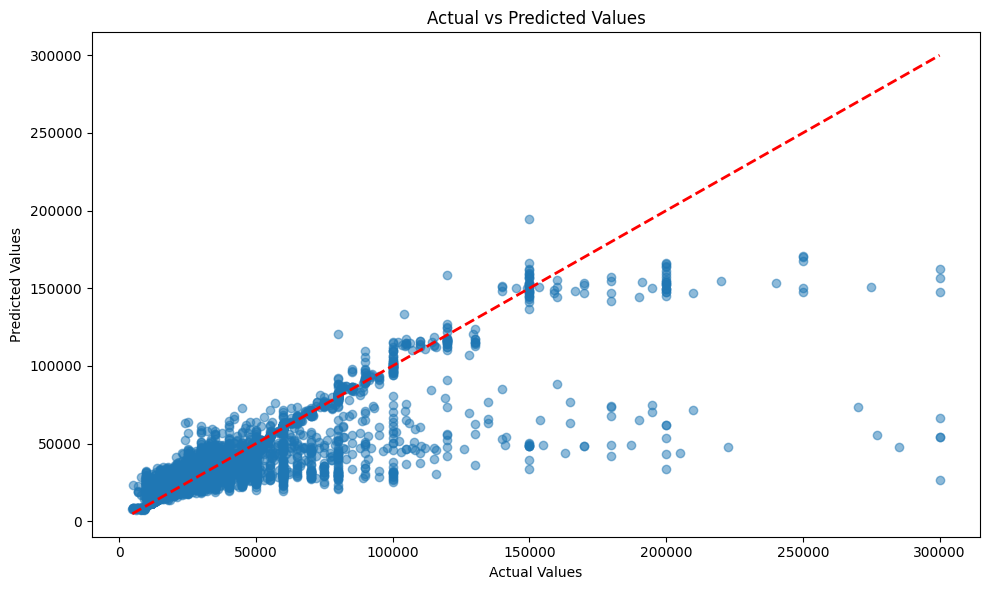

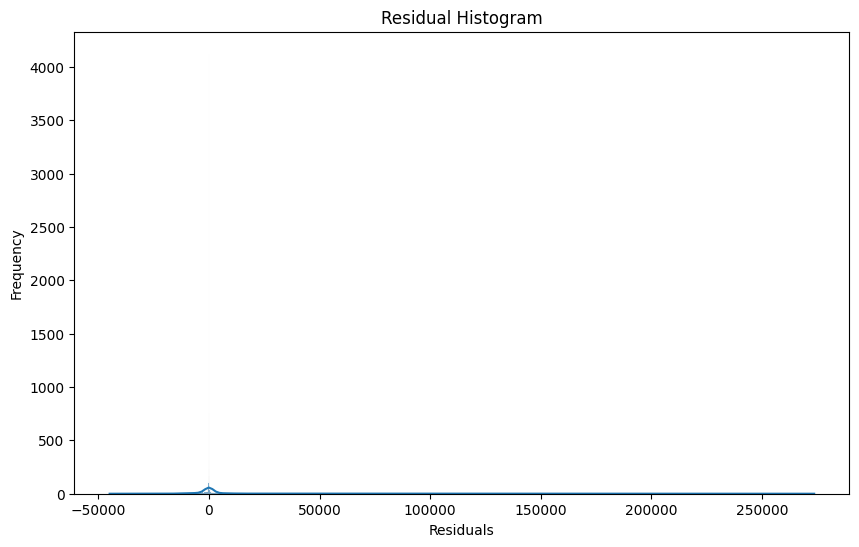

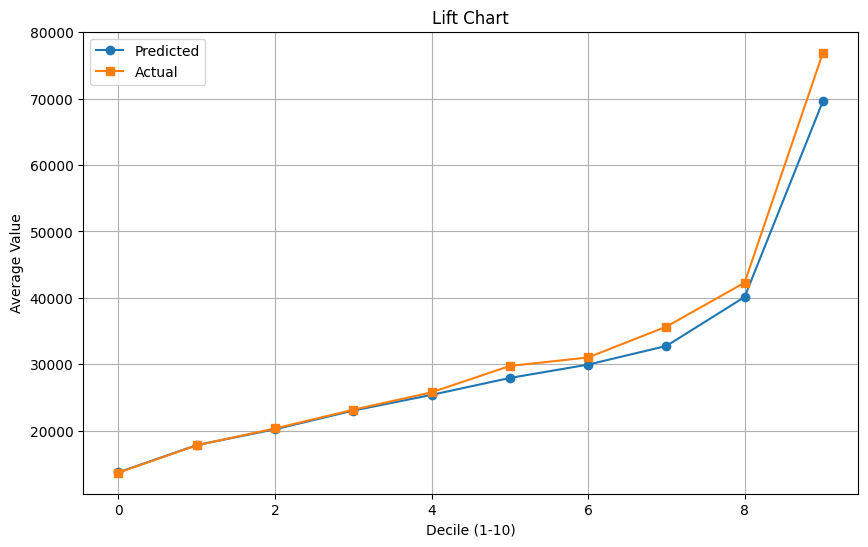

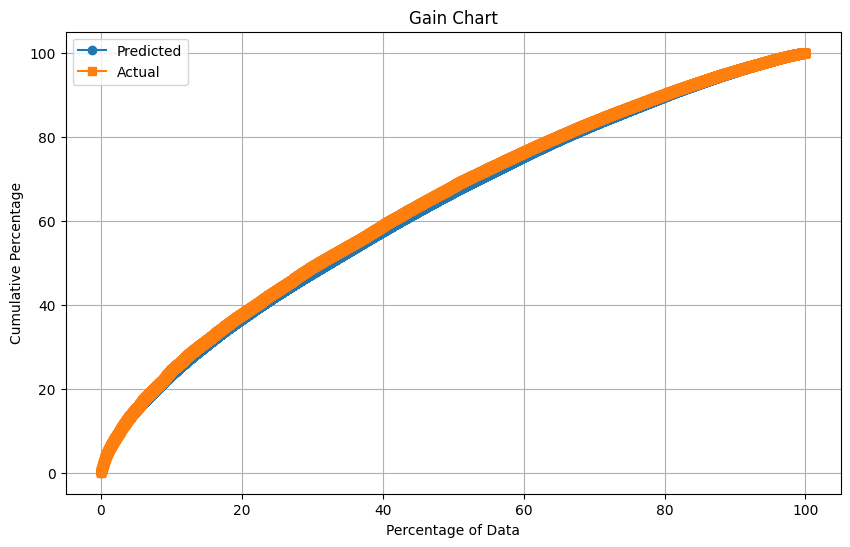


Top 10 Most Important Features:
                             feature  importance
0   inc_encoded_company_name_grouped   75.730488
1                    ib_ln_loan_type    6.687076
2                 ib_ln_industry_new    3.377855
3              ib_ln_education_level    3.065981
4                          ib_ln_age    2.752952
5          ib_ln_employment_type_new    1.956320
6                         ib_ln_city    0.967591
7              ib_ln_doc_type_rolled    0.738409
8                ib_ln_osversion_bin    0.711019
9          ib_ln_source_of_funds_new    0.619289
10                       ib_ln_brand    0.607785
11                     ib_ln_purpose    0.523781
12                 ib_ln_postal_code    0.507921
13             ln_nature_of_work_new    0.434133
14                      ib_ln_gender    0.391178
15              ib_ln_cnt_dependents    0.346074
16        ib_ln_email_primary_domain    0.257892
17                    ib_ln_barangay    0.212567
18           ib_ln_email_primary_tld

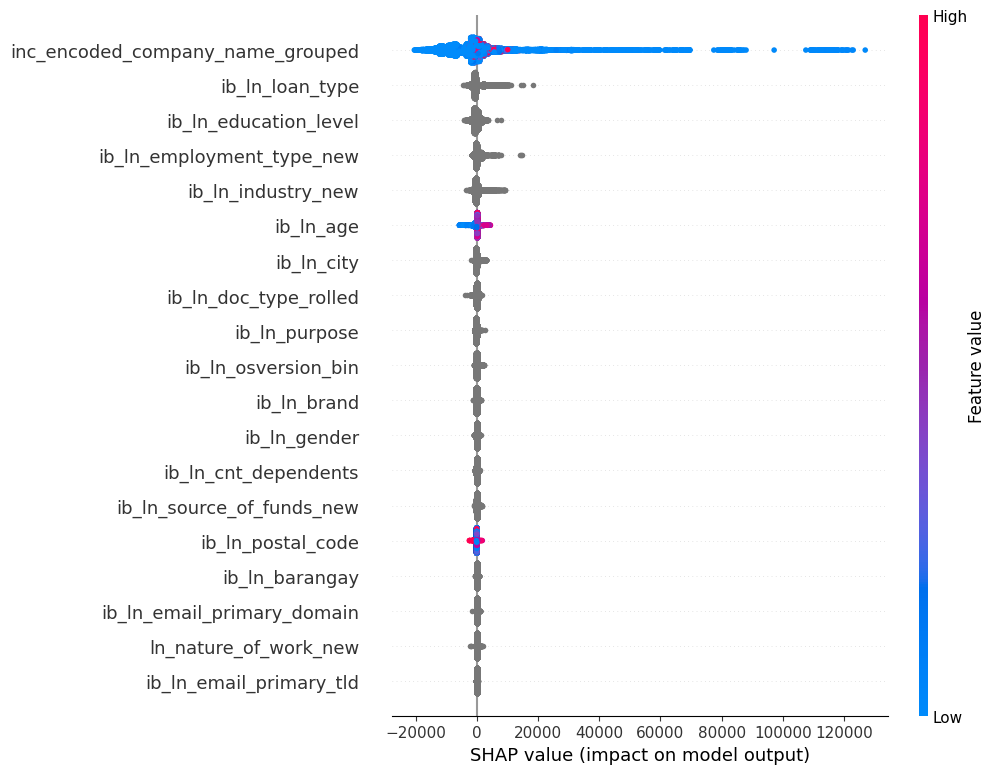

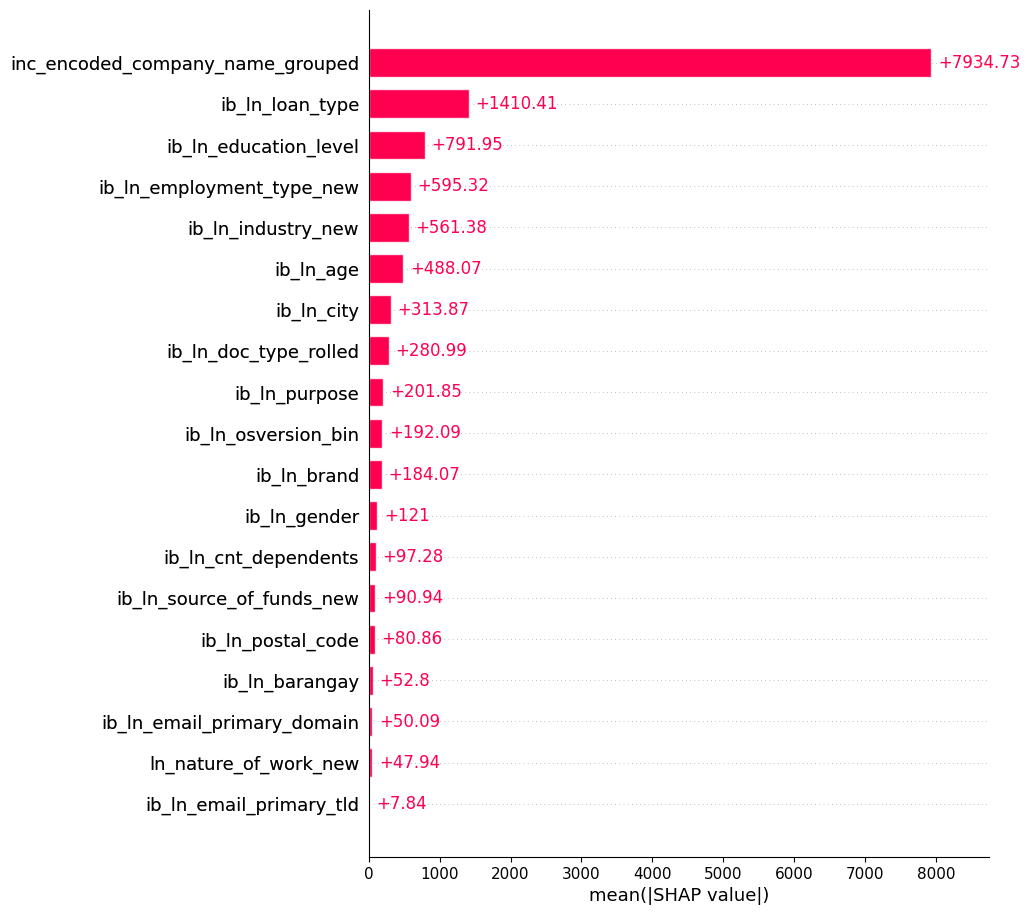

Top Ten Shap features:/t                              feature  shap_importance
2   inc_encoded_company_name_grouped      7934.731641
14                   ib_ln_loan_type      1410.406570
8              ib_ln_education_level       791.952424
11         ib_ln_employment_type_new       595.315165
13                ib_ln_industry_new       561.381935
0                          ib_ln_age       488.072182
5                         ib_ln_city       313.869918
7              ib_ln_doc_type_rolled       280.991244
16                     ib_ln_purpose       201.851468
15               ib_ln_osversion_bin       192.087404
4                        ib_ln_brand       184.067870
12                      ib_ln_gender       121.001023
6               ib_ln_cnt_dependents        97.280348
17         ib_ln_source_of_funds_new        90.941592
1                  ib_ln_postal_code        80.861271
3                     ib_ln_barangay        52.800873
9         ib_ln_email_primary_domain        50.092373
18 

In [91]:
# Define your columns to exclude (optional, there's a default list in the function)
columns_to_exclude = ['cust_id', 'digitalLoanAccountId', 'onboarding_datetime','document_valid_flag','mothersMaidenFullName', 'loan_company_name', 'email', 'text__company_and_industry', 
                     'onb_latitude',   'onb_longitude',  'user_type', 'loan_docNumber',  'Dataselection', 'loanAccountNumber', 'text__cluster', 'onb_city' , 'loan_province', 'loan_type'
                      , 'freq_encodedcompanyName',  'onb_PermanentAddress', 'target_encodedcompanyName', 'datetime__Onboarding_week_of_month', 'datetime__Onboarding_day_of_week', 'datetime__Onboarding_mon_of_year'
                       ]

# Run the model
results = Custom_Catboost_Model(final_df, 'loan_monthly_income', threshold=0.8, columns_to_exclude=columns_to_exclude)
results_Good_customer = results.copy()
# Access results
model = results['model']
metrics = results['metrics']
feature_importance = results['feature_importance']
predictions = results['predictions']
X_train_data = results['X_train']
X_test_data = results['X_test']
y_train_data = results['y_train']
y_test_data = results['y_test']
numerical_cols = results['numerical_cols']
categorical_cols = results['categorical_cols']
top_ten_shap_features = results['top_ten_shap_features']
result_df = results['result_df']

print(f"Top Ten Shap features:/t {top_ten_shap_features}")

In [92]:
result_df.shape

(73869, 3)

In [93]:
X_train_data.shape

(61283, 19)

In [94]:
X_test_data.shape

(12586, 19)

In [95]:
y_train_data.shape

(61283,)

In [96]:
y_test_data.shape

(12586,)

## Save the Model

In [97]:
## Save the model joblib file - model_Good_Customer_Top15SHAPFeatures_Beta1V3_Step2

MODELTOP15FILENAME = f"{CURRENT_DATE}_Beta2_18Features{MODELNAME}_{DATATYPE}_{VERSIONNAME}.joblib"
print(MODELTOP15FILENAME)
destination_blob_name = f"{CLOUDPATH}/{MODELTOP15FILENAME}"
save_model(model,  f"{LOCALPATH}", f"{MODELTOP15FILENAME}")
result_filename = f"result_df_Top18SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
result_df.to_csv(f"{LOCALPATH}/{result_filename}.csv")

numcoldf = pd.DataFrame(numerical_cols, columns=['numerical_cols'])
numfilename = f"Numericalcols_Top18SHAP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
numcoldf.to_csv(f"{LOCALPATH}/{numfilename}.csv")

catcoldf = pd.DataFrame(categorical_cols, columns=['categorical_cols'])
catfilename = f"Categorical_cols_top18SHAPP_{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
catcoldf.to_csv(f"{LOCALPATH}/{catfilename}.csv")

topshapdf = pd.DataFrame(top_ten_shap_features, columns=['top_ten_shap_features'])
topshapfilename = f"top_ten_shap_features_top18SHAP{MODELNAME}_{DATATYPE}_{VERSIONNAME}"
topshapdf.to_csv(f"{LOCALPATH}/{topshapfilename}.csv")

# Serialize the model using joblib
joblib.dump(model, f'{MODELTOP15FILENAME}')

# Upload to Google Cloud Storage
client = storage.Client()
bucket_name = BUCKET_NAME
source_file_name = MODELTOP15FILENAME
destination_blob_name = f"{CLOUDPATH_TARGET}/{MODELTOP15FILENAME}"

# Upload to Google Cloud Storage
client = storage.Client()
bucket_name = BUCKET_NAME
source_file_name = MODELTOP15FILENAME
destination_blob_name = f"{CLOUDPATH}/{MODELTOP15FILENAME}"

bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_filename(source_file_name)

20250212_Beta2_18FeaturesBeta2WithOutApp_Step2_1_0.joblib
Model successfully saved to: /home/jupyter/Models/Income_Estimation_Models/Income_Estimation_Model/20250212_Beta2_18FeaturesBeta2WithOutApp_Step2_1_0.joblib


In [98]:
numcoldf[0:3]

,numerical_cols
0,ib_ln_age
1,ib_ln_postal_code
2,inc_encoded_company_name_grouped


In [99]:
a = numcoldf['numerical_cols'].values.tolist()
b = catcoldf['categorical_cols'].values.tolist()

In [100]:
b

['ib_ln_barangay',
 'ib_ln_brand',
 'ib_ln_city',
 'ib_ln_cnt_dependents',
 'ib_ln_doc_type_rolled',
 'ib_ln_education_level',
 'ib_ln_email_primary_domain',
 'ib_ln_email_primary_tld',
 'ib_ln_employment_type_new',
 'ib_ln_gender',
 'ib_ln_industry_new',
 'ib_ln_loan_type',
 'ib_ln_osversion_bin',
 'ib_ln_purpose',
 'ib_ln_source_of_funds_new',
 'ln_nature_of_work_new']

## Inferencing Good Customer

In [101]:
MODEL = "gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Income_Estimation_Models/20250212_Beta2_18FeaturesBeta2WithOutApp_Step2_1_0.joblib"
ENCODER = "gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib"

In [102]:
from google.cloud import storage
from joblib import load
import tempfile
import os
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Function to download a file from Google Cloud Storage
def download_blob(bucket_name, source_blob_name, destination_file_name):
    """Downloads a blob from the bucket."""
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    blob = bucket.blob(source_blob_name)
    blob.download_to_filename(destination_file_name)
    print(f"Downloaded {source_blob_name} to {destination_file_name}.")

# Main inference function
def load_and_predict_income(df_inference, numerical_cols, categorical_cols,
                          model_path=MODEL,
                          encoded_data_path=ENCODER):
    """
    Complete inference pipeline that loads saved model and encoded data to predict monthly income.
    Handles GCS paths by downloading files locally before loading.
    """
    def reduce_doc_type(doc_type):
        # Define mappings from specific document types to common categories
        doc_type_mappings = {
            'Id Card': 'ID Card',
            'UMID Card': 'UMID Card',
            'Driving License': 'Driving License',
            'ePassport': 'Passport',
            'Professional Id Card': 'Professional ID Card',
            'Social Security Card': 'Social Security Card',
            'Postal Id Card': 'Postal ID Card',
            'Professional Driving License': 'Driving License',
            'Passport': 'Passport'
        }

        # Iterate through the mappings and return the common category if a match is found
        for key, value in doc_type_mappings.items():
            if key in doc_type:
                return value

        # Return 'Other' if no match is found
        return 'Other'
    
    
    def prepare_inference_data(df, numerical_cols, categorical_cols, encoded_data):
        """Prepare data for inference"""
        df_processed = df.copy()
        print("df copied")
        
        if 'ln_docType' in df_processed.columns:
            df_processed['ln_docType'] = df_processed['ln_docType'].apply(reduce_doc_type)
        print("loan doc type reduced")

        # Extract company encoding data
        company_encodings = encoded_data[['loan_company_name', 
                                        'freq_encodedcompanyName', 
                                        'target_encodedcompanyName', 
                                        'encoded_company_name_group']].copy()
        
        print()

        # Merge with encoded company data
        df_processed = df_processed.merge(company_encodings,
                                       left_on ='ln_company_name', right_on ='loan_company_name', how='left')
        
        
        
        # # Handle duplicates
        # duplicate_rows = df_processed[df_processed.duplicated(keep=False)]
        # duplicate_rows_sorted = duplicate_rows.sort_values(by=duplicate_rows.columns[0])
        # top_20_duplicates = duplicate_rows_sorted.head(20)
        
        # print(f"The shape of df_processed is :\t {df_processed.shape}")
        # print(f"The shape of duplicate rows is:\t {duplicate_rows.shape}")
        df_processed_deduplicated = df_processed.drop_duplicates(keep='first')
        df_processed.drop(columns = ['loan_company_name', 'loan_company_name'], inplace = True)
        print(f"The shape of df_processed_deduplicated is:\t{df_processed_deduplicated.shape}")
        df_processed = df_processed_deduplicated.copy()
        print(f"The shape of df_processed is :\t {df_processed.shape}")

        # Fill NaN values with appropriate defaults
        df_processed['freq_encodedcompanyName'] = df_processed['freq_encodedcompanyName'].fillna(0)
        global_mean = encoded_data['target_encodedcompanyName'].mean()
        df_processed['target_encodedcompanyName'] = df_processed['target_encodedcompanyName'].fillna(global_mean)
        df_processed['encoded_company_name_group'] = df_processed['encoded_company_name_group'].fillna(global_mean)
        df_processed.rename(columns={'encoded_company_name_group':'inc_encoded_company_name_grouped'}, inplace = True)

        # Handle categorical and numerical features
        for col in categorical_cols:
            if col in df_processed.columns:
                df_processed[col] = df_processed[col].fillna('Missing').astype(str)
            else:
                df_processed[col] = 'Missing'  # Add missing categorical columns with default value

        for col in numerical_cols:
            if col in df_processed.columns:
                df_processed[col] = pd.to_numeric(df_processed[col], errors='coerce').fillna(0)
            else:
                df_processed[col] = 0  # Add missing numerical columns with default value

        # Ensure all required columns are present
        required_cols = numerical_cols + categorical_cols
        missing_cols = set(required_cols) - set(df_processed.columns)
        if missing_cols:
            print(f"Warning: Missing columns: {missing_cols}")
            for col in missing_cols:
                if col in numerical_cols:
                    df_processed[col] = 0
                else:
                    df_processed[col] = 'Missing'

        # Select only the required columns in the correct order
        X_inference = df_processed[numerical_cols + categorical_cols]

        return X_inference, df_processed
    
    print("Loading model and encoded data...")
    try:
        # Create temporary files for model and encoded data
        with tempfile.NamedTemporaryFile(delete=False, suffix=".joblib") as tmp_model_file, \
             tempfile.NamedTemporaryFile(delete=False, suffix=".joblib") as tmp_encoded_file:
            
            # Download model and encoded data from GCS to temporary files
            if model_path.startswith("gs://"):
                bucket_name = model_path.split("/")[2]
                source_blob_name = "/".join(model_path.split("/")[3:])
                download_blob(bucket_name, source_blob_name, tmp_model_file.name)
                model_path = tmp_model_file.name

            if encoded_data_path.startswith("gs://"):
                bucket_name = encoded_data_path.split("/")[2]
                source_blob_name = "/".join(encoded_data_path.split("/")[3:])
                download_blob(bucket_name, source_blob_name, tmp_encoded_file.name)
                encoded_data_path = tmp_encoded_file.name

            # Load model and encoded data using joblib
            model = load(model_path)
            encoded_data = load(encoded_data_path)
                        
            # Extract numerical and categorical columns from model
            feature_names = model.feature_names_
            print(f"Model feature names: {feature_names}")
            categorical_cols = categorical_cols
            print(f"Categorical columns: {categorical_cols}")
            numerical_cols = [col for col in feature_names if col not in categorical_cols]
            print(f"Numerical columns: {numerical_cols}")
            
            print("Successfully loaded model and encoded data")
            print(f"Number of numerical features: {len(numerical_cols)}")
            print(f"Number of categorical features: {len(categorical_cols)}")
            
            # Prepare the inference data
            X_inference, df_processed = prepare_inference_data(df_inference, numerical_cols, categorical_cols, encoded_data)
            
            # Generate predictions
            print("\nGenerating predictions...")
            predictions = model.predict(X_inference)
            
            # Add predictions to the processed dataframe
            df_processed['predicted_monthly_income'] = predictions
            
            # Calculate difference if actual income is available
            if 'ln_monthly_income' in df_processed.columns:
                df_processed['prediction_difference'] = df_processed['ln_monthly_income'] - df_processed['predicted_monthly_income']
                df_processed['prediction_difference_percentage'] = (
                    (df_processed['prediction_difference'] / df_processed['ln_monthly_income']) * 100).round(2)
            
            # Print prediction statistics
            print("\nPrediction Statistics:")
            print(f"Number of predictions: {len(predictions)}")
            print(f"Mean predicted income: {predictions.mean():.2f}")
            print(f"Median predicted income: {np.median(predictions):.2f}")
            print(f"Min predicted income: {predictions.min():.2f}")
            print(f"Max predicted income: {predictions.max():.2f}")
            
            # Calculate metrics if actual values are available
            if 'ln_monthly_income' in df_processed.columns:
                print("\nAccuracy Metrics:")
#                 mae = mean_absolute_error(df_processed['ln_monthly_income'], predictions)
#                 rmse = np.sqrt(mean_squared_error(df_processed['ln_monthly_income'], predictions))
#                 r2 = r2_score(df_processed['ln_monthly_income'], predictions)
#                 print(f"Mean Absolute Error: {mae:.2f}")
#                 print(f"Root Mean Squared Error: {rmse:.2f}")
#                 print(f"R-squared Score: {r2:.4f}")

                            # Calculate metrics
                print("\nCalculating metrics...")
                mae = mean_absolute_error(df_processed['ln_monthly_income'], predictions)
                mse = mean_squared_error(df_processed['ln_monthly_income'], predictions)
                rmse = np.sqrt(mse)
                r2 = r2_score(df_processed['ln_monthly_income'], predictions)
                mape = mean_absolute_percentage_error(df_processed['ln_monthly_income'], predictions)

                # Print metrics
                print(f"Mean Absolute Error (MAE): {mae:.2f}")
                print(f"Mean Squared Error (MSE): {mse:.2f}")
                print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
                print(f"R-squared (R2): {r2:.4f}")
                print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}")
        
            # Print prediction statistics
            # print("\nPrediction Statistics:")
            # print(f"Number of predictions: {len(predictions)}")
            # print(f"Mean predicted income: {predictions.mean():.2f}")
            # print(f"Median predicted income: {np.median(predictions):.2f}")
            # print(f"Min predicted income: {predictions.min():.2f}")
            # print(f"Max predicted income: {predictions.max():.2f}")
            
            # Clean up temporary files
            os.unlink(tmp_model_file.name)
            os.unlink(tmp_encoded_file.name)

            return predictions, df_processed

    except Exception as e:
        print(f"Error in inference pipeline: {e}")
        raise


### Data Ingestion for Inferencing

In [103]:
# gs://prod-asia-southeast1-tonik-aiml-workspace/Monthly_Income_Estimation/IncomeEstimation_Beta1V3.1/20250115_Beta1V3.1_Step2_dataStep2.csv
project_id = 'prj-prod-dataplatform'
bucket_name = BUCKET_NAME
file_path = f'{CLOUDPATH}/{data_filename}'

df = read_csv_from_gcs(project_id, bucket_name, file_path)
print(f"The shape of the {CLOUDPATH}/{data_filename} is :\t {df.shape}")

The shape of the Monthly_Income_Estimation/Income_Estimation_Models/20250212_Beta2WithOutApp_SIL_Quick1_0_data.csv is :	 (105076, 23)


In [104]:
df.columns.values

array(['digitalLoanAccountId', 'ln_company_name', 'ln_prod_type',
       'ln_education_level', 'industry_description', 'employment_type',
       'ln_age', 'ln_city', 'ln_brand', 'ln_purpose', 'ln_osversion',
       'clean_version', 'ln_doc_type', 'ln_gender', 'source_funds',
       'ln_postal_code', 'dependentsCount', 'onb_email', 'ln_barangay',
       'ln_nature_of_work', 'loan_monthly_income', 'Dataselection',
       'onboarding_datetime'], dtype=object)

In [105]:
df.groupby(['Dataselection'])['digitalLoanAccountId'].count()

Dataselection
OOT_NOV_24     4027
OOT_OCT_24    13912
OOT_SEP_24    13268
Test          12586
Train         61283
Name: digitalLoanAccountId, dtype: int64

### Data cleaning for Inferencing

In [106]:
# X_train, X_test, y_train, y_test, numerical_cols, categorical_cols = prepare_data_cat_model1(dfmerged, 'loan_monthly_income')

# Assuming dfmerged is your original DataFrame
preprocessor = create_preprocessor(df)

# Fit and transform the data
df_transformed = preprocessor.fit_transform(df)

# Inspect the results
print("Transformed dataframe shape:", df_transformed.shape)
print("\nColumns in transformed dataframe:")
print(df_transformed.columns)

# Display the first few rows of the transformed dataframe
print("\nTransformed dataframe head:")
# Now combine the original dfmerged with df_transformed
# First, get the list of columns that were used in transformations to avoid duplicates
transformed_source_cols = ['onb_email', 'ln_osversion', 'clean_version', 'ln_nature_of_work', 
                           ]

# Drop the source columns from dfmerged to avoid duplicates
dfmerged_filtered = df.drop(columns=transformed_source_cols)

# Combine the filtered original dataframe with the transformed features
final_df = pd.concat([dfmerged_filtered, df_transformed], axis=1)
final_df.head()

Transformed dataframe shape: (105076, 4)

Columns in transformed dataframe:
Index(['version__osversionType', 'onb_email__domain', 'onb_email__tld',
       'work__nature_of_work_grouped'],
      dtype='object')

Transformed dataframe head:


,digitalLoanAccountId,ln_company_name,ln_prod_type,ln_education_level,industry_description,employment_type,ln_age,ln_city,ln_brand,ln_purpose,ln_doc_type,ln_gender,source_funds,ln_postal_code,dependentsCount,ln_barangay,loan_monthly_income,Dataselection,onboarding_datetime,version__osversionType,onb_email__domain,onb_email__tld,work__nature_of_work_grouped
0,4085569c-fc38-485b-9eb9-87e23466e91e,Outsource Asia international multi purpose,Appliance,College Graduate,Fin Tech/Financial Services,Employed - Govt. Employee/Govt. Official,41,CITY OF MANILA,realme,"Sala set, Couch, Sofa set",Philippines - Id Card (2020),F,Salary,1001,5 or more,BARANGAY 385,39000.0,OOT_OCT_24,2024-10-26 15:27:29,2-Voyager,gmail.com,com,missing
1,210afa02-21e2-4ecc-8e28-06969222c968,MANILA CITY COUNCIL DEPARTMENT,Appliance,College Undergraduate,Govt. Institution,Employed - Govt. Employee/Govt. Official,37,CITY OF MANILA,realme,Air conditioners,Philippines - UMID Card (2016),F,Salary,1003,2,BARANGAY 378,13000.0,Train,2024-06-19 19:46:52,2-Voyager,gmail.com,com,Govt Employee
2,482de693-4a33-4d1b-aeab-0fbc616e3b88,K1 Wellness And Beauty Spa,Appliance,High School Graduate,Beauty and Health Services,Employed - Private Employee,23,CITY OF MANILA,TECNO,Televisions,Philippines - Id Card (2020),F,Salary,1004,1,BARANGAY 702,16000.0,OOT_NOV_24,2024-11-02 11:41:56,2-Voyager,gmail.com,com,Licensed Professional - Others
3,13f87213-18f9-4c10-88bb-29788f8251a2,Pasay city health office,not applicable,NaN,Hospital and Medical Services,Employed - Private Employee,40,CITY OF MANILA,Apple,Others,Philippines - Professional Id Card (2019),F,Salary,1004,2,BARANGAY 744,40000.0,Train,2023-06-12 22:40:29,3-ComfortSeeker,yahoo.com,com,Licensed Professional - Others
4,313dae44-1e2a-410e-88be-5613416b8fb0,Grab Philippines,Mobile,High School Graduate,Others,Employed - Private Employee,30,CITY OF MANILA,HUAWEI,Mobile Phones,Philippines - UMID Card (2016),M,Salary,1006,2,BARANGAY 289,35000.0,OOT_SEP_24,2024-09-20 14:43:07,2-Voyager,gmail.com,com,Licensed Professional - Others


In [107]:
final_df.rename(columns = {'version__osversionType':'ib_ln_osversion_bin', 
                           'work__nature_of_work_grouped':'ib_ln_nature_of_work_new',
                          'maritalStatus':'ib_ln_marital_status',
                           'ln_prod_type':'ib_ln_loan_type',
                           'ln_education_level':'ib_ln_education_level',
                           'industry_description':'ib_ln_industry_new',
                           'employment_type': 'ib_ln_employment_type_new',
                           'ln_age': 'ib_ln_age',
                           'ln_city': 'ib_ln_city',
                           'ln_brand': 'ib_ln_brand',
                           'ln_purpose':'ib_ln_purpose',
                           'ln_doc_type':'ib_ln_doc_type_rolled',
                           'ln_gender': 'ib_ln_gender',
                           'dependentsCount': 'ib_ln_dependent_count',
                           'loan_postalcode':'ib_ln_postalcode',
                           'source_funds':'ib_ln_source_of_funds_new',
                           'ln_postal_code':'ib_ln_postal_code',
                           'dependentsCount':'ib_ln_cnt_dependents',
                           'onb_email__domain':'ib_ln_email_primary_domain',
                           'onb_email__tld':'ib_ln_email_primary_tld',
                           'ln_barangay':'ib_ln_barangay',
                           'work__nature_of_work_grouped':'ln_nature_of_work_new',                        
                            }, inplace = True)

final_df.columns.values

array(['digitalLoanAccountId', 'ln_company_name', 'ib_ln_loan_type',
       'ib_ln_education_level', 'ib_ln_industry_new',
       'ib_ln_employment_type_new', 'ib_ln_age', 'ib_ln_city',
       'ib_ln_brand', 'ib_ln_purpose', 'ib_ln_doc_type_rolled',
       'ib_ln_gender', 'ib_ln_source_of_funds_new', 'ib_ln_postal_code',
       'ib_ln_cnt_dependents', 'ib_ln_barangay', 'loan_monthly_income',
       'Dataselection', 'onboarding_datetime', 'ib_ln_osversion_bin',
       'ib_ln_email_primary_domain', 'ib_ln_email_primary_tld',
       'ln_nature_of_work_new'], dtype=object)

### Inferencing

In [108]:
# Example usage
predictions_sep24, processed_df_sep24 = load_and_predict_income(
    df_inference=final_df,
    numerical_cols=a
,
    categorical_cols=b
,
)

# # Save the results if needed
# processed_df_sep24.to_csv(f"{LOCALPATH}/{MODELNAME}_{DATATYPE}_{VERSIONNAME}_{PRODUCT_TYPE}_{CURRENT_DATE}_processed_df_sep24_15.csv", index=False)
# print(f"The file is {LOCALPATH}/{MODELNAME}_{DATATYPE}_{VERSIONNAME}_{PRODUCT_TYPE}_{CURRENT_DATE}.csv")

Loading model and encoded data...
Downloaded Monthly_Income_Estimation/Income_Estimation_Models/20250212_Beta2_18FeaturesBeta2WithOutApp_Step2_1_0.joblib to /var/tmp/tmppifxfve6.joblib.
Downloaded Monthly_Income_Estimation/Target_Encoded_Artifacts/companytrgencode.joblib to /var/tmp/tmp97dh_t_q.joblib.
Model feature names: ['ib_ln_age', 'ib_ln_postal_code', 'inc_encoded_company_name_grouped', 'ib_ln_barangay', 'ib_ln_brand', 'ib_ln_city', 'ib_ln_cnt_dependents', 'ib_ln_doc_type_rolled', 'ib_ln_education_level', 'ib_ln_email_primary_domain', 'ib_ln_email_primary_tld', 'ib_ln_employment_type_new', 'ib_ln_gender', 'ib_ln_industry_new', 'ib_ln_loan_type', 'ib_ln_osversion_bin', 'ib_ln_purpose', 'ib_ln_source_of_funds_new', 'ln_nature_of_work_new']
Categorical columns: ['ib_ln_barangay', 'ib_ln_brand', 'ib_ln_city', 'ib_ln_cnt_dependents', 'ib_ln_doc_type_rolled', 'ib_ln_education_level', 'ib_ln_email_primary_domain', 'ib_ln_email_primary_tld', 'ib_ln_employment_type_new', 'ib_ln_gender', '

In [109]:
processed_df_sep24.head()

,digitalLoanAccountId,ln_company_name,ib_ln_loan_type,ib_ln_education_level,ib_ln_industry_new,ib_ln_employment_type_new,ib_ln_age,ib_ln_city,ib_ln_brand,ib_ln_purpose,ib_ln_doc_type_rolled,ib_ln_gender,ib_ln_source_of_funds_new,ib_ln_postal_code,ib_ln_cnt_dependents,ib_ln_barangay,loan_monthly_income,Dataselection,onboarding_datetime,ib_ln_osversion_bin,ib_ln_email_primary_domain,ib_ln_email_primary_tld,ln_nature_of_work_new,loan_company_name,freq_encodedcompanyName,target_encodedcompanyName,inc_encoded_company_name_grouped,predicted_monthly_income
0,4085569c-fc38-485b-9eb9-87e23466e91e,Outsource Asia international multi purpose,Appliance,College Graduate,Fin Tech/Financial Services,Employed - Govt. Employee/Govt. Official,41,CITY OF MANILA,realme,"Sala set, Couch, Sofa set",Philippines - Id Card (2020),F,Salary,1001,5 or more,BARANGAY 385,39000.0,OOT_OCT_24,2024-10-26 15:27:29,2-Voyager,gmail.com,com,missing,Outsource Asia international multi purpose,1.0,31399.224605,3.139922e+04,38262.515277
1,210afa02-21e2-4ecc-8e28-06969222c968,MANILA CITY COUNCIL DEPARTMENT,Appliance,College Undergraduate,Govt. Institution,Employed - Govt. Employee/Govt. Official,37,CITY OF MANILA,realme,Air conditioners,Philippines - UMID Card (2016),F,Salary,1003,2,BARANGAY 378,13000.0,Train,2024-06-19 19:46:52,2-Voyager,gmail.com,com,Govt Employee,MANILA CITY COUNCIL DEPARTMENT,1.0,29774.224605,2.977422e+04,12997.123352
2,482de693-4a33-4d1b-aeab-0fbc616e3b88,K1 Wellness And Beauty Spa,Appliance,High School Graduate,Beauty and Health Services,Employed - Private Employee,23,CITY OF MANILA,TECNO,Televisions,Philippines - Id Card (2020),F,Salary,1004,1,BARANGAY 702,16000.0,OOT_NOV_24,2024-11-02 11:41:56,2-Voyager,gmail.com,com,Licensed Professional - Others,K1 Wellness And Beauty Spa,1.0,29961.724605,2.996172e+04,15999.996209
3,13f87213-18f9-4c10-88bb-29788f8251a2,Pasay city health office,not applicable,Missing,Hospital and Medical Services,Employed - Private Employee,40,CITY OF MANILA,Apple,Others,Philippines - Professional Id Card (2019),F,Salary,1004,2,BARANGAY 744,40000.0,Train,2023-06-12 22:40:29,3-ComfortSeeker,yahoo.com,com,Licensed Professional - Others,Pasay city health office,1.0,31461.724605,3.146172e+04,39465.806039
4,313dae44-1e2a-410e-88be-5613416b8fb0,Grab Philippines,Mobile,High School Graduate,Others,Employed - Private Employee,30,CITY OF MANILA,HUAWEI,Mobile Phones,Philippines - UMID Card (2016),M,Salary,1006,2,BARANGAY 289,35000.0,OOT_SEP_24,2024-09-20 14:43:07,2-Voyager,gmail.com,com,Licensed Professional - Others,Grab Philippines,117.0,33124.148437,3.875525e+06,23518.044619


In [110]:
processed_df_sep24.shape

(105076, 28)

In [111]:
# processed_rename_df = add_column_prefix(processed_df_sep24, 'beta2_inc_', ['digitalLoanAccountId', 'ln_company_name', 'ln_loan_type',
#        'ln_education_level', 'ln_industry_new', 'ln_employment_type_new',
#        'ln_age', 'ln_city', 'ln_brand', 'ln_purpose',
#        'ln_doc_type_rolled', 'ln_gender', 'ln_source_of_funds_new',
#        'ln_postal_code', 'ln_cnt_dependents', 'ln_barangay',
#        'loan_monthly_income', 'Dataselection', 'onboarding_datetime',
#        'ln_osversion_inc_bin', 'ln_email_primary_domain',
#        'onb_email__tld', 'ln_nature_of_work_new', 'loan_company_name',
#        'freq_encodedcompanyName', 'target_encodedcompanyName',
#        'inc_encoded_company_name_grouped', 'predicted_monthly_income'])

In [112]:
processed_df_sep24.columns.values

array(['digitalLoanAccountId', 'ln_company_name', 'ib_ln_loan_type',
       'ib_ln_education_level', 'ib_ln_industry_new',
       'ib_ln_employment_type_new', 'ib_ln_age', 'ib_ln_city',
       'ib_ln_brand', 'ib_ln_purpose', 'ib_ln_doc_type_rolled',
       'ib_ln_gender', 'ib_ln_source_of_funds_new', 'ib_ln_postal_code',
       'ib_ln_cnt_dependents', 'ib_ln_barangay', 'loan_monthly_income',
       'Dataselection', 'onboarding_datetime', 'ib_ln_osversion_bin',
       'ib_ln_email_primary_domain', 'ib_ln_email_primary_tld',
       'ln_nature_of_work_new', 'loan_company_name',
       'freq_encodedcompanyName', 'target_encodedcompanyName',
       'inc_encoded_company_name_grouped', 'predicted_monthly_income'],
      dtype=object)

In [115]:
processed_df_sep24.rename(columns={'predicted_monthly_income':'ib_ln_predicted_monthly_income', 'inc_encoded_company_name_grouped':'ib_inc_encoded_company_name_grouped', 'ln_nature_of_work_new':'ib_ln_nature_of_work_new'}, inplace = True)

In [130]:
beta2inferencedf = processed_df_sep24[['digitalLoanAccountId', 'ib_ln_loan_type',
       'ib_ln_education_level', 'ib_ln_industry_new',
       'ib_ln_employment_type_new', 'ib_ln_age', 'ib_ln_city',
       'ib_ln_brand', 'ib_ln_purpose', 'ib_ln_doc_type_rolled',
       'ib_ln_gender', 'ib_ln_source_of_funds_new', 'ib_ln_postal_code',
       'ib_ln_cnt_dependents', 'ib_ln_barangay',  'ib_ln_osversion_bin', 'ib_ln_email_primary_domain', 'ib_ln_email_primary_tld',
        'ib_inc_encoded_company_name_grouped', 'ib_ln_nature_of_work_new',
       'ib_ln_predicted_monthly_income', 'loan_monthly_income']].copy()

In [131]:
beta2inferencedf.dtypes

digitalLoanAccountId                    object
ib_ln_loan_type                         object
ib_ln_education_level                   object
ib_ln_industry_new                      object
ib_ln_employment_type_new               object
ib_ln_age                                int64
ib_ln_city                              object
ib_ln_brand                             object
ib_ln_purpose                           object
ib_ln_doc_type_rolled                   object
ib_ln_gender                            object
ib_ln_source_of_funds_new               object
ib_ln_postal_code                        int64
ib_ln_cnt_dependents                    object
ib_ln_barangay                          object
ib_ln_osversion_bin                     object
ib_ln_email_primary_domain              object
ib_ln_email_primary_tld                 object
ib_inc_encoded_company_name_grouped    float64
ib_ln_nature_of_work_new                object
ib_ln_predicted_monthly_income         float64
loan_monthly_

In [132]:
from google.cloud import bigquery
import pandas as pd

# Connection to Bigquery
client = bigquery.Client(project='prj-prod-dataplatform')

# Define the dataset and table references
dataset_id = 'risk_mart'
table_id = 'beta2_income_estimation'

# Define the table schema
schema = [
    bigquery.SchemaField("digitalLoanAccountId", "STRING"),
    bigquery.SchemaField("ib_ln_loan_type", "STRING"),
    bigquery.SchemaField("ib_ln_education_level", "STRING"),
    bigquery.SchemaField("ib_ln_industry_new", "STRING"),
    bigquery.SchemaField("ib_ln_employment_type_new", "STRING"),
    bigquery.SchemaField("ib_ln_age", "INT64"),
    bigquery.SchemaField("ib_ln_city", "STRING"),
    bigquery.SchemaField("ib_ln_brand", "STRING"),
    bigquery.SchemaField("ib_ln_purpose", "STRING"),
    bigquery.SchemaField("ib_ln_doc_type_rolled", "STRING"),
    bigquery.SchemaField("ib_ln_gender", "STRING"),
    bigquery.SchemaField("ib_ln_source_of_funds_new", "STRING"),
    bigquery.SchemaField("ib_ln_postal_code", "INT64"),
    bigquery.SchemaField("ib_ln_cnt_dependents", "STRING"),
    bigquery.SchemaField("ia_cic_max_active_contracts_amt", "STRING"),
    bigquery.SchemaField("ib_ln_osversion_bin", "STRING"),
    bigquery.SchemaField("ib_ln_email_primary_domain", "STRING"),
    bigquery.SchemaField("ib_ln_email_primary_tld", "STRING"),
    bigquery.SchemaField("ib_ln_nature_of_work_new", "STRING"),
    bigquery.SchemaField("ib_inc_encoded_company_name_grouped", "FLOAT64"),
    bigquery.SchemaField("ib_ln_predicted_monthly_income", "FLOAT64"),
    bigquery.SchemaField("loan_monthly_income", "FLOAT64"),
]

# Create the dataset reference
dataset_ref = client.dataset(dataset_id)
table_ref = dataset_ref.table(table_id)

# Configure the job with explicit schema and write disposition
job_config = bigquery.LoadJobConfig(
    schema=schema,
    write_disposition=bigquery.WriteDisposition.WRITE_TRUNCATE
)

try:
    # Before loading, ensure DataFrame columns match schema
    required_columns = [field.name for field in schema]
    
    # Check if all required columns exist in the DataFrame
    missing_columns = [col for col in required_columns if col not in beta2inferencedf.columns]
    if missing_columns:
        raise ValueError(f"Missing columns in DataFrame: {missing_columns}")
    
    # Reorder DataFrame columns to match schema
    beta2inferencedf = beta2inferencedf[required_columns]
    
    # Load the DataFrame into BigQuery
    job = client.load_table_from_dataframe(
        beta2inferencedf,
        table_ref,
        job_config=job_config
    )
    
    # Wait for the job to complete
    job.result()
    
    print(f"Successfully loaded {len(beta2inferencedf)} rows into {dataset_id}.{table_id}")
    
except Exception as e:
    print(f"Error loading table: {str(e)}")
    
    # Additional debugging information
    if 'beta2inferencedf' in locals():
        print("\nDataFrame Info:")
        print(beta2inferencedf.info())
        print("\nDataFrame Columns:")
        print(beta2inferencedf.columns.tolist())

Successfully loaded 105076 rows into risk_mart.beta2_income_estimation


In [47]:
import pandas as pd
from google.cloud import bigquery
from datetime import datetime

def transform_data(df):
    # Get current date in the correct format
    current_date = datetime.now().date()
    
    # Initialize list to store transformed records
    transformed_records = []
    
    # Iterate through each row and column
    for index, row in df.iterrows():
        # Get the digital loan account ID for this row
        digital_loan_account_id = row['digitalLoanAccountId']
        
        for column in df.columns:
            # Skip columns that don't start with 'beta2_inc_'
            if not column.startswith('beta2_inc_'):
                continue
                
            # Parse column name
            parts = column.split('_')
            model_name = 'beta2'
            source = 'inc'
            
            # Get item name by removing prefix
            item_name = '_'.join(parts[2:])
            
            # Create transformed record
            transformed_record = {
                'Index': digital_loan_account_id,  # Add the index column
                'Model_Name': model_name,
                'Model_Version': 'v1.1',  # Fixed the version field name
                'Source': source,
                'Item_Name': item_name,
                'Feature_Version': 'v1.1',
                'Dated': current_date,
                'Value': str(row[column]),
                'Is_Active': 1,
                'Is_Deleted': 0
            }
            transformed_records.append(transformed_record)
    
    # Create new dataframe with explicit data types
    transformed_df = pd.DataFrame(transformed_records)
    
    # Convert the Dated column to datetime
    transformed_df['Dated'] = pd.to_datetime(transformed_df['Dated']).dt.date
    
    # Ensure other columns have the correct data types
    transformed_df['Index'] = transformed_df['Index'].astype(str)
    transformed_df['Model_Name'] = transformed_df['Model_Name'].astype(str)
    transformed_df['Model_Version'] = transformed_df['Model_Version'].astype(str)  # Fixed field name
    transformed_df['Source'] = transformed_df['Source'].astype(str)
    transformed_df['Item_Name'] = transformed_df['Item_Name'].astype(str)
    transformed_df['Feature_Version'] = transformed_df['Feature_Version'].astype(str)
    transformed_df['Value'] = transformed_df['Value'].astype(str)
    transformed_df['Is_Active'] = transformed_df['Is_Active'].astype(int)
    transformed_df['Is_Deleted'] = transformed_df['Is_Deleted'].astype(int)
    
    return transformed_df

def create_bigquery_table(transformed_df, project_id, dataset_id, table_id):
    # Initialize BigQuery client
    client = bigquery.Client(project=project_id)
    
    # Define table schema
    schema = [
        bigquery.SchemaField("Index", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("Model_Name", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("Model_Version", "STRING", mode="REQUIRED"),  # Fixed typo in field name
        bigquery.SchemaField("Source", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("Item_Name", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("Feature_Version", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("Dated", "DATE", mode="REQUIRED"),
        bigquery.SchemaField("Value", "STRING", mode="REQUIRED"),
        bigquery.SchemaField("Is_Active", "INTEGER", mode="REQUIRED"),
        bigquery.SchemaField("Is_Deleted", "INTEGER", mode="REQUIRED")
    ]
    
    # Create table reference
    table_ref = f"{project_id}.{dataset_id}.{table_id}"
    table = bigquery.Table(table_ref, schema=schema)
    
    # Create the table
    table = client.create_table(table, exists_ok=True)
    
    # Load data into BigQuery
    job_config = bigquery.LoadJobConfig(
        schema=schema,
        write_disposition="WRITE_TRUNCATE"
    )
    
    # Load the data
    job = client.load_table_from_dataframe(
        transformed_df,
        table_ref,
        job_config=job_config
    )
    
    job.result()  # Wait for the job to complete



In [48]:
def main():
    # Transform the data
    transformed_df = transform_data(processed_rename_df)
    
    # Create BigQuery table
    project_id = 'prj-prod-dataplatform'
    dataset_id = 'risk_mart'
    table_id = 'beta2_income_estimation_vector1'
    
    create_bigquery_table(transformed_df, project_id, dataset_id, table_id)

if __name__ == "__main__":
    main()